In [1]:
import yaml
import umap

import scanpy as sc
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

from math import floor

from carot.utils import score_transports_and_targets_combinations, get_source_target_transport
from cmonge.utils import load_config
from carot.trainers.conditional_monge_trainer import ConditionalMongeTrainer
from carot.datasets.conditional_loader import ConditionalDataModule

/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
default_colors = {
    "blue": "#648FFF",
    "purple": "#785EF0",
    "pink": "#DC267F",
    "orange": "#FE6100",
    "yellow": "#FFB000",
    "grey": "#DDDDDD",
}

ot_map = {
    "source": default_colors["blue"],
    "target": default_colors["pink"],
    "transport": default_colors["yellow"],
    "rest": default_colors["grey"]
}

In [3]:
features = "/Users/alicedriessen/Box/LegacyFromOldColleagues/Alice/CAR_Tcells/Model/OT/functional_and_score_genes.txt"

logger_path = "/Users/alicedriessen/Box/LegacyFromOldColleagues/Alice/CAR_Tcells/Model/OT/notebook_logger.json"
base_config_path = "/Users/alicedriessen/Box/LegacyFromOldColleagues/Alice/CAR_Tcells/Model/conditional-monge/experiments/cmonge/LN_True_grad_acc_4_cosine/"
base_ckpt_path =   "/Users/alicedriessen/Box/LegacyFromOldColleagues/Alice/CAR_Tcells/Model/conditional-monge/experiments/cmonge/LN_True_grad_acc_4_cosine/"
base_fig_save =    "/Users/alicedriessen/Box/LegacyFromOldColleagues/Alice/CAR_Tcells/Figures/transport_UMAPs/cmonge/"

# conCAROT - ID - TRAINED ON ALL CARS

In [4]:
for subset in ["CD4", "CD8"]:
    adata = sc.read_h5ad(f'/Users/alicedriessen/Box/LegacyFromOldColleagues/Alice/CAR_Tcells/Model/OT/{subset}.h5ad')
    adata.X = adata.layers['logcounts']
    with open(features, "r") as f:
        genes = f.read().splitlines()
    sel_adata = adata[:, genes]
    umapper = umap.UMAP(random_state=1234)
    Y1 = umapper.fit_transform(sel_adata.X)
    sel_adata.obsm["X_umap"] = Y1

    config_path = f"{base_config_path}{subset}_esm_XL_tail_dim_FuncScore/config.yaml"
    config = load_config(config_path)
    config.model.checkpointing_path = f"{base_ckpt_path}{subset}_esm_XL_tail_dim_FuncScore/model"
    config.data.file_path = f"/Users/alicedriessen/Box/LegacyFromOldColleagues/Alice/CAR_Tcells/Model/OT/{subset}.h5ad"
    config.data.features = features
    config.data.drugs_path = "/Users/alicedriessen/Box/LegacyFromOldColleagues/Alice/CAR_Tcells/Model/OT/CAR_variants.txt"
    config.model.embedding.model_dir = "/Users/alicedriessen/Box/LegacyFromOldColleagues/Alice/CAR_Tcells/Model/OT/embedding/"

    for car in sel_adata.obs["CAR_Variant"].unique():
        if car in ["NA-NA-NA", "NA-NA-z"]:
            continue
        print(car)
        batch_size = min(sum(sel_adata.obs["CAR_Variant"]==car), sum(sel_adata.obs["CAR_Variant"]=="NA-NA-NA"))
        batch_size = floor(batch_size * config.data.split[1])
        config.data.batch_size=batch_size
        config.condition.conditions = [car]
        config.model.embedding.model_dir = "/Users/alicedriessen/Box/LegacyFromOldColleagues/Alice/CAR_Tcells/Model/OT/embedding/"

        datamodule = ConditionalDataModule(config.data, config.condition, config.ae)
        trainer = ConditionalMongeTrainer.load_checkpoint(
            jobid=1,
            logger_path=logger_path, 
            config=config.model, 
            datamodule=datamodule, 
            ckpt_path=config.model.checkpointing_path
            )
    
        all_expr, all_meta = get_source_target_transport(datamodule=datamodule, 
                                                         trainer=trainer,
                                                         conditions=[car])
    
    
        
        Y2 = umapper.transform(all_expr)
    
        all_meta[["UMAP1", "UMAP2"]] = Y2
    
        sns.scatterplot(x=Y1[:, 0], y=Y1[:, 1], color=default_colors["grey"], s=5, alpha=0.8, linewidth=0)
        sns.scatterplot(data=all_meta, x="UMAP1", y="UMAP2", hue="dtype", s=20, palette=ot_map, alpha=0.95, linewidth=0.15)
        plt.legend([],[], frameon=False)
        plt.tick_params(which="both", axis="both", bottom=False, left=False, labelbottom=False, labelleft=False)
        plt.xlabel("UMAP1", fontsize=18)
        plt.ylabel("UMAP2", fontsize=18)
        plt.savefig(f"{base_fig_save}{subset}_{car}_source_transport_target.png", bbox_inches="tight", dpi=300)
        plt.savefig(f"{base_fig_save}{subset}_{car}_source_transport_target.pdf", bbox_inches="tight", dpi=300)
        plt.close()

/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/var/folders/02/gztwz1tj1051mtt_ykv6v7940000gn/T/ipykernel_26231/1549458385.py:9: ImplicitModificationWarning: Setting element `.obsm['X_umap']` of view, initializing view as actual.
  sel_adata.obsm["X_umap"] = Y1


41BB-41BB-z


2025-08-22 19:53:53.146 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for 41BB-41BB-z
2025-08-22 19:53:53.463 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 19:53:53.605 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (746,), valid: (187,), test: (0,).
2025-08-22 19:53:53.605 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-22 19:53:53.606 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 19:53:53.606 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 19:53:54.815 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(151, 5120)


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


41BB-CD28-z


2025-08-22 19:54:01.915 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for 41BB-CD28-z
2025-08-22 19:54:02.367 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 19:54:02.375 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (1085,), valid: (272,), test: (0,).
2025-08-22 19:54:02.375 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-22 19:54:02.375 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 19:54:02.375 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 19:54:02.408 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 

Evaluating on validation set
(151, 5120)
41BB-CD40-z


2025-08-22 19:54:03.462 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for 41BB-CD40-z
2025-08-22 19:54:04.064 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 19:54:04.070 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (776,), valid: (195,), test: (0,).
2025-08-22 19:54:04.070 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-22 19:54:04.070 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 19:54:04.071 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 19:54:04.096 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: '

Evaluating on validation set
(151, 5120)
41BB-CTLA4-z


2025-08-22 19:54:05.162 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for 41BB-CTLA4-z
2025-08-22 19:54:05.707 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 19:54:05.717 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (248,), valid: (63,), test: (0,).
2025-08-22 19:54:05.717 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-22 19:54:05.717 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 19:54:05.718 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 19:54:05.758 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(62, 5120)


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


41BB-IL15RA-z


2025-08-22 19:54:07.445 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for 41BB-IL15RA-z
2025-08-22 19:54:07.935 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 19:54:07.951 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (840,), valid: (211,), test: (0,).
2025-08-22 19:54:07.951 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-22 19:54:07.951 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 19:54:07.952 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 19:54:07.990 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning:

Evaluating on validation set
(151, 5120)
41BB-NA-z


2025-08-22 19:54:09.042 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for 41BB-NA-z
2025-08-22 19:54:09.638 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 19:54:09.649 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (765,), valid: (192,), test: (0,).
2025-08-22 19:54:09.650 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-22 19:54:09.650 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 19:54:09.650 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 19:54:09.685 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'fo

Evaluating on validation set
(151, 5120)
CD28-41BB-z


2025-08-22 19:54:11.224 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD28-41BB-z
2025-08-22 19:54:11.606 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 19:54:11.611 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (172,), valid: (43,), test: (0,).
2025-08-22 19:54:11.612 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-22 19:54:11.612 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 19:54:11.612 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 19:54:11.637 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(43, 5120)


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


CD28-CD28-z


2025-08-22 19:54:13.397 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD28-CD28-z
2025-08-22 19:54:13.880 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 19:54:13.890 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (833,), valid: (209,), test: (0,).
2025-08-22 19:54:13.890 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-22 19:54:13.890 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 19:54:13.890 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 19:54:13.923 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: '

Evaluating on validation set
(151, 5120)
CD28-CD40-z


2025-08-22 19:54:14.919 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD28-CD40-z
2025-08-22 19:54:15.492 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 19:54:15.498 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (818,), valid: (205,), test: (0,).
2025-08-22 19:54:15.498 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-22 19:54:15.498 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 19:54:15.499 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 19:54:15.534 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: '

Evaluating on validation set
(151, 5120)
CD28-CTLA4-z


2025-08-22 19:54:16.602 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD28-CTLA4-z
2025-08-22 19:54:17.151 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 19:54:17.157 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (214,), valid: (54,), test: (0,).
2025-08-22 19:54:17.158 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-22 19:54:17.158 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 19:54:17.158 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 19:54:17.184 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(53, 5120)


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


CD28-IL15RA-z


2025-08-22 19:54:18.804 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD28-IL15RA-z
2025-08-22 19:54:19.359 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 19:54:19.365 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (1153,), valid: (289,), test: (0,).
2025-08-22 19:54:19.365 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-22 19:54:19.365 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 19:54:19.365 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 19:54:19.392 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning

Evaluating on validation set
(151, 5120)
CD28-NA-z


2025-08-22 19:54:20.448 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD28-NA-z
2025-08-22 19:54:21.055 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 19:54:21.064 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (1145,), valid: (287,), test: (0,).
2025-08-22 19:54:21.064 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-22 19:54:21.064 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 19:54:21.065 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 19:54:21.091 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'f

Evaluating on validation set
(151, 5120)
CD40-41BB-z


2025-08-22 19:54:22.341 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD40-41BB-z
2025-08-22 19:54:22.895 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 19:54:22.904 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (556,), valid: (140,), test: (0,).
2025-08-22 19:54:22.904 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-22 19:54:22.904 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 19:54:22.905 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 19:54:22.934 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(139, 5120)


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


CD40-CD28-z


2025-08-22 19:54:25.947 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD40-CD28-z
2025-08-22 19:54:26.171 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 19:54:26.177 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (590,), valid: (148,), test: (0,).
2025-08-22 19:54:26.177 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-22 19:54:26.177 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 19:54:26.177 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 19:54:26.201 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(147, 5120)


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


CD40-CD40-z


2025-08-22 19:54:27.730 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD40-CD40-z
2025-08-22 19:54:27.980 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 19:54:27.986 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (542,), valid: (136,), test: (0,).
2025-08-22 19:54:27.986 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-22 19:54:27.987 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 19:54:27.987 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 19:54:28.010 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(135, 5120)


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


CD40-CTLA4-z


2025-08-22 19:54:29.458 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD40-CTLA4-z
2025-08-22 19:54:29.683 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 19:54:29.688 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (259,), valid: (65,), test: (0,).
2025-08-22 19:54:29.688 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-22 19:54:29.689 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 19:54:29.689 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 19:54:29.711 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(64, 5120)


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


CD40-IL15RA-z


2025-08-22 19:54:31.082 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD40-IL15RA-z
2025-08-22 19:54:31.340 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 19:54:31.346 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (645,), valid: (162,), test: (0,).
2025-08-22 19:54:31.346 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-22 19:54:31.346 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 19:54:31.346 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 19:54:31.371 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning:

Evaluating on validation set
(151, 5120)
CD40-NA-z


2025-08-22 19:54:32.195 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD40-NA-z
2025-08-22 19:54:32.423 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 19:54:32.429 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (794,), valid: (199,), test: (0,).
2025-08-22 19:54:32.429 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-22 19:54:32.429 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 19:54:32.429 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 19:54:32.452 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'fo

Evaluating on validation set
(151, 5120)
CTLA4-41BB-z


2025-08-22 19:54:33.464 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CTLA4-41BB-z
2025-08-22 19:54:33.760 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 19:54:33.765 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (188,), valid: (48,), test: (0,).
2025-08-22 19:54:33.766 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-22 19:54:33.766 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 19:54:33.766 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 19:54:33.788 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(47, 5120)


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


CTLA4-CD28-z


2025-08-22 19:54:35.463 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CTLA4-CD28-z
2025-08-22 19:54:35.761 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 19:54:35.768 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (452,), valid: (113,), test: (0,).
2025-08-22 19:54:35.768 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-22 19:54:35.769 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 19:54:35.769 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 19:54:35.791 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(113, 5120)


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


CTLA4-CD40-z


2025-08-22 19:54:37.455 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CTLA4-CD40-z
2025-08-22 19:54:37.758 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 19:54:37.764 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (162,), valid: (41,), test: (0,).
2025-08-22 19:54:37.764 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-22 19:54:37.764 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 19:54:37.765 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 19:54:37.788 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(40, 5120)


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


CTLA4-CTLA4-z


2025-08-22 19:54:39.426 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CTLA4-CTLA4-z
2025-08-22 19:54:39.911 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 19:54:39.916 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (222,), valid: (56,), test: (0,).
2025-08-22 19:54:39.917 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-22 19:54:39.917 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 19:54:39.917 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 19:54:39.945 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(55, 5120)


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


CTLA4-IL15RA-z


2025-08-22 19:54:41.679 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CTLA4-IL15RA-z
2025-08-22 19:54:42.127 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 19:54:42.135 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (152,), valid: (38,), test: (0,).
2025-08-22 19:54:42.135 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-22 19:54:42.136 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 19:54:42.136 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 19:54:42.162 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(38, 5120)


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


CTLA4-NA-z


2025-08-22 19:54:43.898 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CTLA4-NA-z
2025-08-22 19:54:44.496 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 19:54:44.503 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (171,), valid: (43,), test: (0,).
2025-08-22 19:54:44.503 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-22 19:54:44.503 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 19:54:44.503 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 19:54:44.528 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(42, 5120)


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


IL15RA-41BB-z


2025-08-22 19:54:46.126 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for IL15RA-41BB-z
2025-08-22 19:54:46.660 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 19:54:46.668 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (894,), valid: (224,), test: (0,).
2025-08-22 19:54:46.668 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-22 19:54:46.668 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 19:54:46.668 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 19:54:46.700 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning:

Evaluating on validation set
(151, 5120)
IL15RA-CD28-z


2025-08-22 19:54:47.741 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for IL15RA-CD28-z
2025-08-22 19:54:48.338 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 19:54:48.345 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (991,), valid: (248,), test: (0,).
2025-08-22 19:54:48.345 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-22 19:54:48.345 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 19:54:48.345 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 19:54:48.373 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning:

Evaluating on validation set
(151, 5120)
IL15RA-CD40-z


2025-08-22 19:54:49.493 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for IL15RA-CD40-z
2025-08-22 19:54:50.182 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 19:54:50.192 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (790,), valid: (198,), test: (0,).
2025-08-22 19:54:50.192 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-22 19:54:50.192 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 19:54:50.193 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 19:54:50.230 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning:

Evaluating on validation set
(151, 5120)
IL15RA-CTLA4-z


2025-08-22 19:54:51.344 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for IL15RA-CTLA4-z
2025-08-22 19:54:51.957 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 19:54:51.965 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (364,), valid: (92,), test: (0,).
2025-08-22 19:54:51.965 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-22 19:54:51.966 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 19:54:51.966 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 19:54:51.998 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(91, 5120)


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


IL15RA-IL15RA-z


2025-08-22 19:54:54.437 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for IL15RA-IL15RA-z
2025-08-22 19:54:55.008 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 19:54:55.016 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (1110,), valid: (278,), test: (0,).
2025-08-22 19:54:55.016 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-22 19:54:55.016 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 19:54:55.017 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 19:54:55.054 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarni

Evaluating on validation set
(151, 5120)
IL15RA-NA-z


2025-08-22 19:54:57.597 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for IL15RA-NA-z
2025-08-22 19:54:58.268 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 19:54:58.384 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (1123,), valid: (281,), test: (0,).
2025-08-22 19:54:58.386 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-22 19:54:58.387 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 19:54:58.390 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 19:54:58.461 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 

Evaluating on validation set
(151, 5120)


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/var/folders/02/gztwz1tj1051mtt_ykv6v7940000gn/T/ipykernel_26231/1549458385.py:9: ImplicitModificationWarning: Setting element `.obsm['X_umap']` of view, initializing view as actual.
  sel_adata.obsm["X_umap"] = Y1


41BB-41BB-z


2025-08-22 19:55:20.846 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for 41BB-41BB-z
2025-08-22 19:55:21.211 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 19:55:21.219 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (628,), valid: (157,), test: (0,).
2025-08-22 19:55:21.219 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-22 19:55:21.219 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 19:55:21.219 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 19:55:23.395 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(157, 5120)


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


41BB-CD28-z


2025-08-22 19:55:26.676 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for 41BB-CD28-z
2025-08-22 19:55:26.935 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 19:55:26.941 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (581,), valid: (146,), test: (0,).
2025-08-22 19:55:26.941 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-22 19:55:26.941 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 19:55:26.941 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 19:55:26.989 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(145, 5120)


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


41BB-CD40-z


2025-08-22 19:55:28.537 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for 41BB-CD40-z
2025-08-22 19:55:28.764 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 19:55:28.769 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (377,), valid: (95,), test: (0,).
2025-08-22 19:55:28.770 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-22 19:55:28.770 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 19:55:28.770 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 19:55:28.795 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(94, 5120)


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


41BB-CTLA4-z


2025-08-22 19:55:30.192 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for 41BB-CTLA4-z
2025-08-22 19:55:30.417 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 19:55:30.423 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (212,), valid: (53,), test: (0,).
2025-08-22 19:55:30.423 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-22 19:55:30.423 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 19:55:30.423 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 19:55:30.451 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 

Evaluating on validation set
(53, 5120)
41BB-IL15RA-z


2025-08-22 19:55:31.183 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for 41BB-IL15RA-z
2025-08-22 19:55:31.412 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 19:55:31.419 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (844,), valid: (212,), test: (0,).
2025-08-22 19:55:31.419 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-22 19:55:31.419 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 19:55:31.419 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 19:55:31.443 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(211, 5120)


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


41BB-NA-z


2025-08-22 19:55:33.081 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for 41BB-NA-z
2025-08-22 19:55:33.351 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 19:55:33.357 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (789,), valid: (198,), test: (0,).
2025-08-22 19:55:33.358 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-22 19:55:33.358 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 19:55:33.358 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 19:55:33.380 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(197, 5120)


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


CD28-41BB-z


2025-08-22 19:55:35.070 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD28-41BB-z
2025-08-22 19:55:35.360 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 19:55:35.366 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (206,), valid: (52,), test: (0,).
2025-08-22 19:55:35.366 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-22 19:55:35.367 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 19:55:35.367 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 19:55:35.390 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(51, 5120)


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


CD28-CD28-z


2025-08-22 19:55:36.958 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD28-CD28-z
2025-08-22 19:55:37.228 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 19:55:37.234 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (672,), valid: (168,), test: (0,).
2025-08-22 19:55:37.234 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-22 19:55:37.235 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 19:55:37.235 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 19:55:37.259 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(168, 5120)


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


CD28-CD40-z


2025-08-22 19:55:38.998 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD28-CD40-z
2025-08-22 19:55:39.368 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 19:55:39.374 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (526,), valid: (132,), test: (0,).
2025-08-22 19:55:39.374 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-22 19:55:39.375 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 19:55:39.375 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 19:55:39.403 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(131, 5120)


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


CD28-CTLA4-z


2025-08-22 19:55:41.138 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD28-CTLA4-z
2025-08-22 19:55:41.482 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 19:55:41.490 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (350,), valid: (88,), test: (0,).
2025-08-22 19:55:41.490 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-22 19:55:41.491 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 19:55:41.491 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 19:55:41.515 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(87, 5120)


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


CD28-IL15RA-z


2025-08-22 19:55:43.121 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD28-IL15RA-z
2025-08-22 19:55:43.562 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 19:55:43.572 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (719,), valid: (180,), test: (0,).
2025-08-22 19:55:43.573 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-22 19:55:43.573 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 19:55:43.573 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 19:55:43.608 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(179, 5120)


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


CD28-NA-z


2025-08-22 19:55:45.397 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD28-NA-z
2025-08-22 19:55:45.914 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 19:55:45.921 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (883,), valid: (221,), test: (0,).
2025-08-22 19:55:45.921 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-22 19:55:45.922 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 19:55:45.922 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 19:55:45.945 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(220, 5120)


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


CD40-41BB-z


2025-08-22 19:55:48.294 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD40-41BB-z
2025-08-22 19:55:48.507 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 19:55:48.514 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (487,), valid: (122,), test: (0,).
2025-08-22 19:55:48.514 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-22 19:55:48.514 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 19:55:48.514 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 19:55:48.540 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(121, 5120)


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


CD40-CD28-z


2025-08-22 19:55:49.973 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD40-CD28-z
2025-08-22 19:55:50.185 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 19:55:50.191 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (774,), valid: (194,), test: (0,).
2025-08-22 19:55:50.191 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-22 19:55:50.192 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 19:55:50.192 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 19:55:50.216 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(193, 5120)


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


CD40-CD40-z


2025-08-22 19:55:51.693 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD40-CD40-z
2025-08-22 19:55:51.917 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 19:55:51.923 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (1089,), valid: (273,), test: (0,).
2025-08-22 19:55:51.923 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-22 19:55:51.924 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 19:55:51.924 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 19:55:51.948 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(272, 5120)


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


CD40-CTLA4-z


2025-08-22 19:55:53.573 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD40-CTLA4-z
2025-08-22 19:55:53.784 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 19:55:53.790 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (559,), valid: (140,), test: (0,).
2025-08-22 19:55:53.790 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-22 19:55:53.790 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 19:55:53.790 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 19:55:53.813 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning:

Evaluating on validation set
(139, 5120)
CD40-IL15RA-z


2025-08-22 19:55:54.592 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD40-IL15RA-z
2025-08-22 19:55:54.809 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 19:55:54.814 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (552,), valid: (139,), test: (0,).
2025-08-22 19:55:54.815 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-22 19:55:54.815 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 19:55:54.815 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 19:55:54.838 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(138, 5120)


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


CD40-NA-z


2025-08-22 19:55:56.300 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD40-NA-z
2025-08-22 19:55:56.518 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 19:55:56.524 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (1004,), valid: (251,), test: (0,).
2025-08-22 19:55:56.524 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-22 19:55:56.524 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 19:55:56.524 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 19:55:56.546 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(251, 5120)


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


CTLA4-41BB-z


2025-08-22 19:55:58.326 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CTLA4-41BB-z
2025-08-22 19:55:58.620 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 19:55:58.625 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (137,), valid: (35,), test: (0,).
2025-08-22 19:55:58.625 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-22 19:55:58.626 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 19:55:58.626 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 19:55:58.648 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(34, 5120)


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


CTLA4-CD28-z


2025-08-22 19:56:00.171 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CTLA4-CD28-z
2025-08-22 19:56:00.445 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 19:56:00.452 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (202,), valid: (51,), test: (0,).
2025-08-22 19:56:00.452 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-22 19:56:00.452 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 19:56:00.453 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 19:56:00.477 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(50, 5120)


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


CTLA4-CD40-z


2025-08-22 19:56:02.142 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CTLA4-CD40-z
2025-08-22 19:56:02.469 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 19:56:02.475 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (220,), valid: (56,), test: (0,).
2025-08-22 19:56:02.475 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-22 19:56:02.475 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 19:56:02.476 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 19:56:02.503 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 

Evaluating on validation set
(55, 5120)
CTLA4-CTLA4-z


2025-08-22 19:56:03.457 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CTLA4-CTLA4-z
2025-08-22 19:56:03.818 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 19:56:03.825 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (97,), valid: (25,), test: (0,).
2025-08-22 19:56:03.825 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-22 19:56:03.825 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 19:56:03.826 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 19:56:03.851 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(24, 5120)


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


CTLA4-IL15RA-z


2025-08-22 19:56:05.464 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CTLA4-IL15RA-z
2025-08-22 19:56:05.961 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 19:56:05.975 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (187,), valid: (47,), test: (0,).
2025-08-22 19:56:05.975 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-22 19:56:05.975 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 19:56:05.976 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 19:56:06.011 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(46, 5120)


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


CTLA4-NA-z


2025-08-22 19:56:07.590 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CTLA4-NA-z
2025-08-22 19:56:08.041 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 19:56:08.046 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (201,), valid: (51,), test: (0,).
2025-08-22 19:56:08.047 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-22 19:56:08.047 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 19:56:08.047 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 19:56:08.074 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'f

Evaluating on validation set
(50, 5120)
IL15RA-41BB-z


2025-08-22 19:56:08.935 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for IL15RA-41BB-z
2025-08-22 19:56:09.424 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 19:56:09.434 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (964,), valid: (242,), test: (0,).
2025-08-22 19:56:09.434 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-22 19:56:09.435 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 19:56:09.435 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 19:56:09.469 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(241, 5120)


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


IL15RA-CD28-z


2025-08-22 19:56:11.300 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for IL15RA-CD28-z
2025-08-22 19:56:11.797 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 19:56:11.804 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (628,), valid: (157,), test: (0,).
2025-08-22 19:56:11.804 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-22 19:56:11.804 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 19:56:11.804 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 19:56:11.828 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning

Evaluating on validation set
(157, 5120)
IL15RA-CD40-z


2025-08-22 19:56:12.852 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for IL15RA-CD40-z
2025-08-22 19:56:13.335 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 19:56:13.345 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (1258,), valid: (315,), test: (0,).
2025-08-22 19:56:13.345 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-22 19:56:13.345 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 19:56:13.345 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 19:56:13.373 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(284, 5120)


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


IL15RA-CTLA4-z


2025-08-22 19:56:15.287 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for IL15RA-CTLA4-z
2025-08-22 19:56:15.758 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 19:56:15.766 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (936,), valid: (234,), test: (0,).
2025-08-22 19:56:15.766 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-22 19:56:15.766 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 19:56:15.767 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 19:56:15.796 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(234, 5120)


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


IL15RA-IL15RA-z


2025-08-22 19:56:17.548 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for IL15RA-IL15RA-z
2025-08-22 19:56:17.994 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 19:56:18.000 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (489,), valid: (123,), test: (0,).
2025-08-22 19:56:18.001 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-22 19:56:18.001 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 19:56:18.001 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 19:56:18.026 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(122, 5120)


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


IL15RA-NA-z


2025-08-22 19:56:19.751 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for IL15RA-NA-z
2025-08-22 19:56:20.256 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 19:56:20.263 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (925,), valid: (232,), test: (0,).
2025-08-22 19:56:20.263 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-22 19:56:20.263 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 19:56:20.264 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 19:56:20.290 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(231, 5120)


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


41BB-41BB-z


2025-08-22 19:56:45.012 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for 41BB-41BB-z
2025-08-22 19:56:45.233 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 19:56:45.238 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (746,), valid: (187,), test: (0,).
2025-08-22 19:56:45.239 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-22 19:56:45.239 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 19:56:45.239 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 19:56:45.267 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: '

Evaluating on validation set
(151, 5120)
41BB-CD28-z


2025-08-22 19:56:47.007 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for 41BB-CD28-z
2025-08-22 19:56:47.230 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 19:56:47.236 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (1085,), valid: (272,), test: (0,).
2025-08-22 19:56:47.236 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-22 19:56:47.236 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 19:56:47.236 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 19:56:47.259 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 

Evaluating on validation set
(151, 5120)
41BB-CD40-z


2025-08-22 19:56:47.715 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for 41BB-CD40-z
2025-08-22 19:56:47.940 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 19:56:47.946 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (776,), valid: (195,), test: (0,).
2025-08-22 19:56:47.946 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-22 19:56:47.946 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 19:56:47.946 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 19:56:47.971 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: '

Evaluating on validation set
(151, 5120)
41BB-CTLA4-z


2025-08-22 19:56:48.434 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for 41BB-CTLA4-z
2025-08-22 19:56:48.656 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 19:56:48.662 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (248,), valid: (63,), test: (0,).
2025-08-22 19:56:48.662 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-22 19:56:48.662 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 19:56:48.663 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 19:56:48.685 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: '

Evaluating on validation set
(62, 5120)
41BB-IL15RA-z


2025-08-22 19:56:49.068 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for 41BB-IL15RA-z
2025-08-22 19:56:49.290 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 19:56:49.296 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (840,), valid: (211,), test: (0,).
2025-08-22 19:56:49.296 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-22 19:56:49.296 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 19:56:49.296 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 19:56:49.319 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning:

Evaluating on validation set
(151, 5120)
41BB-NA-z


2025-08-22 19:56:50.001 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for 41BB-NA-z
2025-08-22 19:56:50.318 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 19:56:50.324 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (765,), valid: (192,), test: (0,).
2025-08-22 19:56:50.324 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-22 19:56:50.324 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 19:56:50.324 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 19:56:50.347 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'fo

Evaluating on validation set
(151, 5120)
CD28-41BB-z


2025-08-22 19:56:51.019 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD28-41BB-z
2025-08-22 19:56:51.314 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 19:56:51.322 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (172,), valid: (43,), test: (0,).
2025-08-22 19:56:51.322 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-22 19:56:51.322 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 19:56:51.323 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 19:56:51.346 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'f

Evaluating on validation set
(43, 5120)
CD28-CD28-z


2025-08-22 19:56:51.982 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD28-CD28-z
2025-08-22 19:56:52.361 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 19:56:52.374 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (833,), valid: (209,), test: (0,).
2025-08-22 19:56:52.374 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-22 19:56:52.374 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 19:56:52.375 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 19:56:52.407 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: '

Evaluating on validation set
(151, 5120)
CD28-CD40-z


2025-08-22 19:56:53.173 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD28-CD40-z
2025-08-22 19:56:53.530 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 19:56:53.540 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (818,), valid: (205,), test: (0,).
2025-08-22 19:56:53.540 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-22 19:56:53.541 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 19:56:53.541 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 19:56:53.576 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: '

Evaluating on validation set
(151, 5120)
CD28-CTLA4-z


2025-08-22 19:56:54.285 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD28-CTLA4-z
2025-08-22 19:56:54.699 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 19:56:54.706 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (214,), valid: (54,), test: (0,).
2025-08-22 19:56:54.707 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-22 19:56:54.707 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 19:56:54.708 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 19:56:54.733 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: '

Evaluating on validation set
(53, 5120)
CD28-IL15RA-z


2025-08-22 19:56:55.389 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD28-IL15RA-z
2025-08-22 19:56:55.967 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 19:56:55.977 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (1153,), valid: (289,), test: (0,).
2025-08-22 19:56:55.977 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-22 19:56:55.977 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 19:56:55.977 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 19:56:56.020 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning

Evaluating on validation set
(151, 5120)
CD28-NA-z


2025-08-22 19:56:56.681 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD28-NA-z
2025-08-22 19:56:57.217 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 19:56:57.225 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (1145,), valid: (287,), test: (0,).
2025-08-22 19:56:57.225 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-22 19:56:57.225 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 19:56:57.225 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 19:56:57.253 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'f

Evaluating on validation set
(151, 5120)
CD40-41BB-z


2025-08-22 19:56:57.929 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD40-41BB-z
2025-08-22 19:56:58.520 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 19:56:58.527 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (556,), valid: (140,), test: (0,).
2025-08-22 19:56:58.528 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-22 19:56:58.528 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 19:56:58.528 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 19:56:58.571 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: '

Evaluating on validation set
(139, 5120)
CD40-CD28-z


2025-08-22 19:56:59.248 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD40-CD28-z
2025-08-22 19:56:59.832 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 19:56:59.849 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (590,), valid: (148,), test: (0,).
2025-08-22 19:56:59.849 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-22 19:56:59.850 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 19:56:59.850 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 19:56:59.880 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: '

Evaluating on validation set
(147, 5120)
CD40-CD40-z


2025-08-22 19:57:00.542 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD40-CD40-z
2025-08-22 19:57:01.071 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 19:57:01.078 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (542,), valid: (136,), test: (0,).
2025-08-22 19:57:01.078 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-22 19:57:01.078 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 19:57:01.078 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 19:57:01.103 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: '

Evaluating on validation set
(135, 5120)
CD40-CTLA4-z


2025-08-22 19:57:01.778 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD40-CTLA4-z
2025-08-22 19:57:02.313 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 19:57:02.321 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (259,), valid: (65,), test: (0,).
2025-08-22 19:57:02.321 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-22 19:57:02.321 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 19:57:02.321 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 19:57:02.348 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: '

Evaluating on validation set
(64, 5120)
CD40-IL15RA-z


2025-08-22 19:57:02.891 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD40-IL15RA-z
2025-08-22 19:57:03.438 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 19:57:03.444 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (645,), valid: (162,), test: (0,).
2025-08-22 19:57:03.445 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-22 19:57:03.445 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 19:57:03.445 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 19:57:03.474 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning:

Evaluating on validation set
(151, 5120)
CD40-NA-z


2025-08-22 19:57:04.102 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD40-NA-z
2025-08-22 19:57:04.653 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 19:57:04.660 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (794,), valid: (199,), test: (0,).
2025-08-22 19:57:04.660 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-22 19:57:04.660 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 19:57:04.660 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 19:57:04.691 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'fo

Evaluating on validation set
(151, 5120)
CTLA4-41BB-z


2025-08-22 19:57:05.329 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CTLA4-41BB-z
2025-08-22 19:57:05.931 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 19:57:05.940 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (188,), valid: (48,), test: (0,).
2025-08-22 19:57:05.940 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-22 19:57:05.940 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 19:57:05.940 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 19:57:05.977 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: '

Evaluating on validation set
(47, 5120)
CTLA4-CD28-z


2025-08-22 19:57:06.645 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CTLA4-CD28-z
2025-08-22 19:57:07.232 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 19:57:07.239 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (452,), valid: (113,), test: (0,).
2025-08-22 19:57:07.240 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-22 19:57:07.240 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 19:57:07.240 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 19:57:07.269 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 

Evaluating on validation set
(113, 5120)
CTLA4-CD40-z


2025-08-22 19:57:07.908 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CTLA4-CD40-z
2025-08-22 19:57:08.460 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 19:57:08.472 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (162,), valid: (41,), test: (0,).
2025-08-22 19:57:08.472 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-22 19:57:08.473 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 19:57:08.473 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 19:57:08.507 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: '

Evaluating on validation set
(40, 5120)
CTLA4-CTLA4-z


2025-08-22 19:57:09.099 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CTLA4-CTLA4-z
2025-08-22 19:57:09.645 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 19:57:09.652 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (222,), valid: (56,), test: (0,).
2025-08-22 19:57:09.652 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-22 19:57:09.653 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 19:57:09.653 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 19:57:09.684 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 

Evaluating on validation set
(55, 5120)
CTLA4-IL15RA-z


2025-08-22 19:57:10.283 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CTLA4-IL15RA-z
2025-08-22 19:57:10.837 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 19:57:10.848 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (152,), valid: (38,), test: (0,).
2025-08-22 19:57:10.848 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-22 19:57:10.848 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 19:57:10.849 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 19:57:10.886 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning:

Evaluating on validation set
(38, 5120)
CTLA4-NA-z


2025-08-22 19:57:11.507 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CTLA4-NA-z
2025-08-22 19:57:12.065 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 19:57:12.075 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (171,), valid: (43,), test: (0,).
2025-08-22 19:57:12.075 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-22 19:57:12.075 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 19:57:12.076 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 19:57:12.116 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'fo

Evaluating on validation set
(42, 5120)
IL15RA-41BB-z


2025-08-22 19:57:12.817 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for IL15RA-41BB-z
2025-08-22 19:57:13.329 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 19:57:13.340 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (894,), valid: (224,), test: (0,).
2025-08-22 19:57:13.340 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-22 19:57:13.340 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 19:57:13.340 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 19:57:13.395 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning:

Evaluating on validation set
(151, 5120)
IL15RA-CD28-z


2025-08-22 19:57:14.182 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for IL15RA-CD28-z
2025-08-22 19:57:14.781 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 19:57:14.792 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (991,), valid: (248,), test: (0,).
2025-08-22 19:57:14.793 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-22 19:57:14.793 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 19:57:14.793 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 19:57:14.830 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning:

Evaluating on validation set
(151, 5120)
IL15RA-CD40-z


2025-08-22 19:57:16.110 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for IL15RA-CD40-z
2025-08-22 19:57:16.848 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 19:57:16.866 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (790,), valid: (198,), test: (0,).
2025-08-22 19:57:16.866 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-22 19:57:16.866 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 19:57:16.867 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 19:57:16.930 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning:

Evaluating on validation set
(151, 5120)
IL15RA-CTLA4-z


2025-08-22 19:57:18.178 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for IL15RA-CTLA4-z
2025-08-22 19:57:18.660 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 19:57:18.669 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (364,), valid: (92,), test: (0,).
2025-08-22 19:57:18.670 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-22 19:57:18.670 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 19:57:18.670 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 19:57:18.702 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning:

Evaluating on validation set
(91, 5120)
IL15RA-IL15RA-z


2025-08-22 19:57:20.000 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for IL15RA-IL15RA-z
2025-08-22 19:57:20.484 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 19:57:20.493 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (1110,), valid: (278,), test: (0,).
2025-08-22 19:57:20.493 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-22 19:57:20.493 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 19:57:20.494 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 19:57:20.553 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarni

Evaluating on validation set
(151, 5120)
IL15RA-NA-z


2025-08-22 19:57:21.451 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for IL15RA-NA-z
2025-08-22 19:57:22.027 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 19:57:22.034 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (1123,), valid: (281,), test: (0,).
2025-08-22 19:57:22.034 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-22 19:57:22.034 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 19:57:22.035 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 19:57:22.066 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 

Evaluating on validation set
(151, 5120)


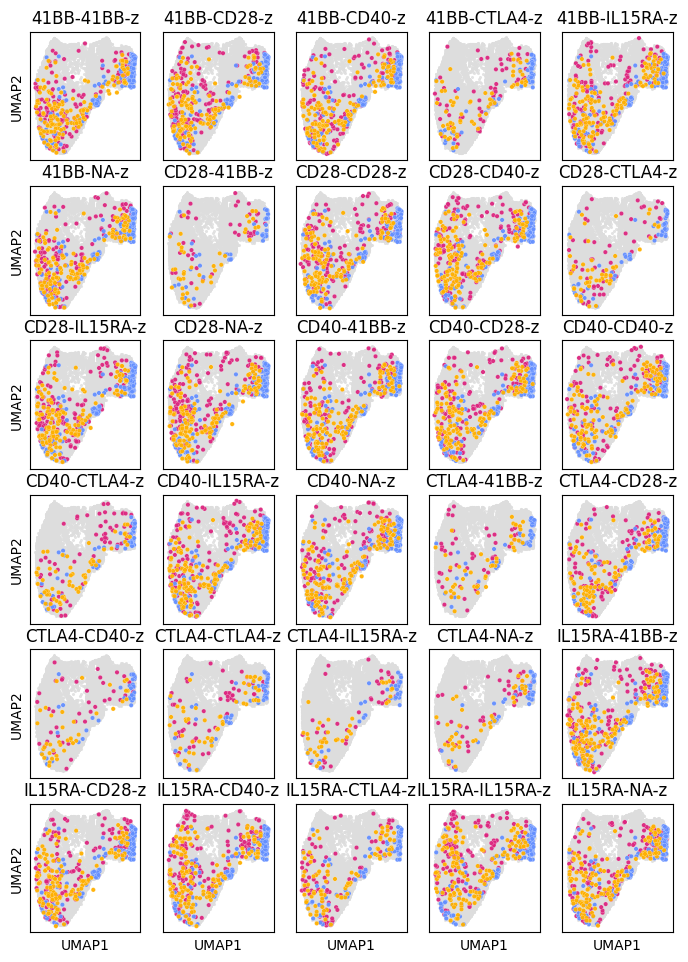

/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


41BB-41BB-z


2025-08-22 19:57:54.217 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for 41BB-41BB-z
2025-08-22 19:57:54.417 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 19:57:54.423 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (628,), valid: (157,), test: (0,).
2025-08-22 19:57:54.424 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-22 19:57:54.424 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 19:57:54.424 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 19:57:54.498 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 

Evaluating on validation set
(157, 5120)
41BB-CD28-z


2025-08-22 19:57:56.346 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for 41BB-CD28-z
2025-08-22 19:57:56.560 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 19:57:56.566 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (581,), valid: (146,), test: (0,).
2025-08-22 19:57:56.566 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-22 19:57:56.566 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 19:57:56.566 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 19:57:56.589 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 

Evaluating on validation set
(145, 5120)
41BB-CD40-z


2025-08-22 19:57:57.079 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for 41BB-CD40-z
2025-08-22 19:57:57.354 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 19:57:57.360 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (377,), valid: (95,), test: (0,).
2025-08-22 19:57:57.360 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-22 19:57:57.361 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 19:57:57.361 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 19:57:57.383 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: '

Evaluating on validation set
(94, 5120)
41BB-CTLA4-z


2025-08-22 19:57:57.807 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for 41BB-CTLA4-z
2025-08-22 19:57:58.023 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 19:57:58.029 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (212,), valid: (53,), test: (0,).
2025-08-22 19:57:58.029 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-22 19:57:58.030 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 19:57:58.030 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 19:57:58.054 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 

Evaluating on validation set
(53, 5120)
41BB-IL15RA-z


2025-08-22 19:57:58.410 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for 41BB-IL15RA-z
2025-08-22 19:57:58.626 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 19:57:58.632 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (844,), valid: (212,), test: (0,).
2025-08-22 19:57:58.633 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-22 19:57:58.633 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 19:57:58.633 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 19:57:58.655 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning

Evaluating on validation set
(211, 5120)
41BB-NA-z


2025-08-22 19:57:59.299 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for 41BB-NA-z
2025-08-22 19:57:59.572 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 19:57:59.582 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (789,), valid: (198,), test: (0,).
2025-08-22 19:57:59.583 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-22 19:57:59.583 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 19:57:59.583 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 19:57:59.605 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'f

Evaluating on validation set
(197, 5120)
CD28-41BB-z


2025-08-22 19:58:00.379 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD28-41BB-z
2025-08-22 19:58:00.647 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 19:58:00.654 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (206,), valid: (52,), test: (0,).
2025-08-22 19:58:00.654 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-22 19:58:00.655 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 19:58:00.655 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 19:58:00.678 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: '

Evaluating on validation set
(51, 5120)
CD28-CD28-z


2025-08-22 19:58:01.285 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD28-CD28-z
2025-08-22 19:58:01.562 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 19:58:01.569 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (672,), valid: (168,), test: (0,).
2025-08-22 19:58:01.570 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-22 19:58:01.570 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 19:58:01.570 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 19:58:01.604 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 

Evaluating on validation set
(168, 5120)
CD28-CD40-z


2025-08-22 19:58:02.343 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD28-CD40-z
2025-08-22 19:58:02.639 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 19:58:02.647 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (526,), valid: (132,), test: (0,).
2025-08-22 19:58:02.648 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-22 19:58:02.648 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 19:58:02.648 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 19:58:02.677 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 

Evaluating on validation set
(131, 5120)
CD28-CTLA4-z


2025-08-22 19:58:03.393 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD28-CTLA4-z
2025-08-22 19:58:03.726 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 19:58:03.734 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (350,), valid: (88,), test: (0,).
2025-08-22 19:58:03.734 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-22 19:58:03.735 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 19:58:03.735 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 19:58:03.760 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 

Evaluating on validation set
(87, 5120)
CD28-IL15RA-z


2025-08-22 19:58:04.402 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD28-IL15RA-z
2025-08-22 19:58:04.757 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 19:58:04.766 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (719,), valid: (180,), test: (0,).
2025-08-22 19:58:04.766 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-22 19:58:04.766 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 19:58:04.766 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 19:58:04.792 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning

Evaluating on validation set
(179, 5120)
CD28-NA-z


2025-08-22 19:58:05.496 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD28-NA-z
2025-08-22 19:58:05.921 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 19:58:05.930 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (883,), valid: (221,), test: (0,).
2025-08-22 19:58:05.930 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-22 19:58:05.931 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 19:58:05.931 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 19:58:05.967 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'f

Evaluating on validation set
(220, 5120)
CD40-41BB-z


2025-08-22 19:58:06.682 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD40-41BB-z
2025-08-22 19:58:07.100 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 19:58:07.108 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (487,), valid: (122,), test: (0,).
2025-08-22 19:58:07.108 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-22 19:58:07.109 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 19:58:07.109 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 19:58:07.134 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 

Evaluating on validation set
(121, 5120)
CD40-CD28-z


2025-08-22 19:58:07.715 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD40-CD28-z
2025-08-22 19:58:08.140 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 19:58:08.152 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (774,), valid: (194,), test: (0,).
2025-08-22 19:58:08.152 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-22 19:58:08.152 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 19:58:08.153 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 19:58:08.179 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 

Evaluating on validation set
(193, 5120)
CD40-CD40-z


2025-08-22 19:58:08.834 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD40-CD40-z
2025-08-22 19:58:09.252 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 19:58:09.259 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (1089,), valid: (273,), test: (0,).
2025-08-22 19:58:09.260 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-22 19:58:09.260 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 19:58:09.260 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 19:58:09.285 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning:

Evaluating on validation set
(272, 5120)
CD40-CTLA4-z


2025-08-22 19:58:10.047 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD40-CTLA4-z
2025-08-22 19:58:10.473 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 19:58:10.481 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (559,), valid: (140,), test: (0,).
2025-08-22 19:58:10.481 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-22 19:58:10.482 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 19:58:10.482 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 19:58:10.515 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning:

Evaluating on validation set
(139, 5120)
CD40-IL15RA-z


2025-08-22 19:58:11.127 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD40-IL15RA-z
2025-08-22 19:58:11.539 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 19:58:11.546 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (552,), valid: (139,), test: (0,).
2025-08-22 19:58:11.547 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-22 19:58:11.547 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 19:58:11.547 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 19:58:11.572 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning

Evaluating on validation set
(138, 5120)
CD40-NA-z


2025-08-22 19:58:12.163 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD40-NA-z
2025-08-22 19:58:12.589 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 19:58:12.597 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (1004,), valid: (251,), test: (0,).
2025-08-22 19:58:12.597 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-22 19:58:12.597 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 19:58:12.598 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 19:58:12.628 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: '

Evaluating on validation set
(251, 5120)
CTLA4-41BB-z


2025-08-22 19:58:13.339 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CTLA4-41BB-z
2025-08-22 19:58:13.815 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 19:58:13.823 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (137,), valid: (35,), test: (0,).
2025-08-22 19:58:13.824 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-22 19:58:13.824 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 19:58:13.824 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 19:58:13.852 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 

Evaluating on validation set
(34, 5120)
CTLA4-CD28-z


2025-08-22 19:58:14.369 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CTLA4-CD28-z
2025-08-22 19:58:14.795 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 19:58:14.804 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (202,), valid: (51,), test: (0,).
2025-08-22 19:58:14.804 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-22 19:58:14.804 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 19:58:14.804 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 19:58:14.834 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 

Evaluating on validation set
(50, 5120)
CTLA4-CD40-z


2025-08-22 19:58:15.415 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CTLA4-CD40-z
2025-08-22 19:58:15.841 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 19:58:15.850 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (220,), valid: (56,), test: (0,).
2025-08-22 19:58:15.850 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-22 19:58:15.850 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 19:58:15.850 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 19:58:15.881 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 

Evaluating on validation set
(55, 5120)
CTLA4-CTLA4-z


2025-08-22 19:58:16.457 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CTLA4-CTLA4-z
2025-08-22 19:58:16.929 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 19:58:16.937 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (97,), valid: (25,), test: (0,).
2025-08-22 19:58:16.937 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-22 19:58:16.937 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 19:58:16.937 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 19:58:16.970 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 

Evaluating on validation set
(24, 5120)
CTLA4-IL15RA-z


2025-08-22 19:58:17.692 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CTLA4-IL15RA-z
2025-08-22 19:58:18.222 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 19:58:18.231 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (187,), valid: (47,), test: (0,).
2025-08-22 19:58:18.231 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-22 19:58:18.232 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 19:58:18.232 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 19:58:18.261 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning

Evaluating on validation set
(46, 5120)
CTLA4-NA-z


2025-08-22 19:58:18.846 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CTLA4-NA-z
2025-08-22 19:58:19.262 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 19:58:19.270 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (201,), valid: (51,), test: (0,).
2025-08-22 19:58:19.270 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-22 19:58:19.270 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 19:58:19.271 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 19:58:19.296 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'f

Evaluating on validation set
(50, 5120)
IL15RA-41BB-z


2025-08-22 19:58:19.837 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for IL15RA-41BB-z
2025-08-22 19:58:20.301 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 19:58:20.310 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (964,), valid: (242,), test: (0,).
2025-08-22 19:58:20.310 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-22 19:58:20.310 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 19:58:20.311 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 19:58:20.344 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning

Evaluating on validation set
(241, 5120)
IL15RA-CD28-z


2025-08-22 19:58:21.140 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for IL15RA-CD28-z
2025-08-22 19:58:21.692 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 19:58:21.700 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (628,), valid: (157,), test: (0,).
2025-08-22 19:58:21.700 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-22 19:58:21.700 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 19:58:21.701 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 19:58:21.736 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning

Evaluating on validation set
(157, 5120)
IL15RA-CD40-z


2025-08-22 19:58:22.413 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for IL15RA-CD40-z
2025-08-22 19:58:22.920 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 19:58:22.932 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (1258,), valid: (315,), test: (0,).
2025-08-22 19:58:22.932 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-22 19:58:22.933 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 19:58:22.933 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 19:58:22.962 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarnin

Evaluating on validation set
(284, 5120)
IL15RA-CTLA4-z


2025-08-22 19:58:23.753 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for IL15RA-CTLA4-z
2025-08-22 19:58:24.183 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 19:58:24.193 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (936,), valid: (234,), test: (0,).
2025-08-22 19:58:24.193 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-22 19:58:24.193 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 19:58:24.194 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 19:58:24.222 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarnin

Evaluating on validation set
(234, 5120)
IL15RA-IL15RA-z


2025-08-22 19:58:24.928 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for IL15RA-IL15RA-z
2025-08-22 19:58:25.388 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 19:58:25.395 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (489,), valid: (123,), test: (0,).
2025-08-22 19:58:25.395 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-22 19:58:25.396 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 19:58:25.396 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 19:58:25.423 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarni

Evaluating on validation set
(122, 5120)
IL15RA-NA-z


2025-08-22 19:58:26.067 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for IL15RA-NA-z
2025-08-22 19:58:26.616 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 19:58:26.625 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (925,), valid: (232,), test: (0,).
2025-08-22 19:58:26.625 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-22 19:58:26.625 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 19:58:26.626 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 19:58:26.658 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 

Evaluating on validation set
(231, 5120)


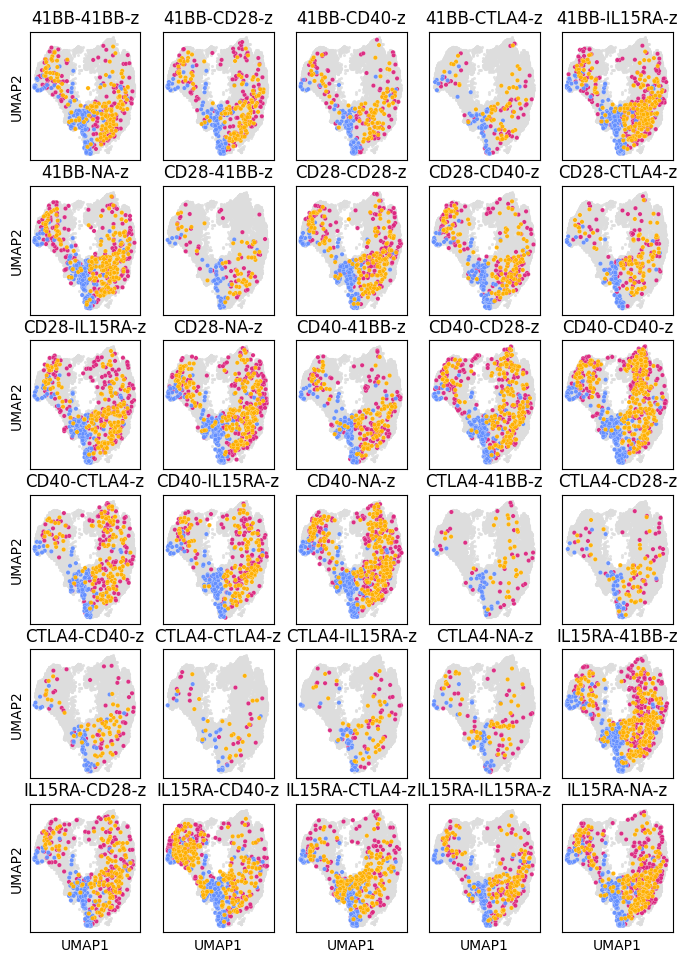

In [5]:
for subset in ["CD4", "CD8"]:
    adata = sc.read_h5ad(f'/Users/alicedriessen/Box/LegacyFromOldColleagues/Alice/CAR_Tcells/Model/OT/{subset}.h5ad')
    adata.X = adata.layers['logcounts']
    with open(features, "r") as f:
        genes = f.read().splitlines()
    sel_adata = adata[:, genes]
    umapper = umap.UMAP(random_state=1234)
    Y1 = umapper.fit_transform(sel_adata.X)

    fig, axes = plt.subplots(nrows=6,ncols=5, sharex=True, sharey=True, figsize=(8.3, 11.7))
    flat_axes = axes.flatten()
    i =0

    config_path = f"{base_config_path}{subset}_esm_XL_tail_dim_FuncScore/config.yaml"
    config = load_config(config_path)
    config.model.checkpointing_path = f"{base_ckpt_path}{subset}_esm_XL_tail_dim_FuncScore/model"
    config.data.file_path = f"/Users/alicedriessen/Box/LegacyFromOldColleagues/Alice/CAR_Tcells/Model/OT/{subset}.h5ad"
    config.data.features = features
    config.data.drugs_path = "/Users/alicedriessen/Box/LegacyFromOldColleagues/Alice/CAR_Tcells/Model/OT/CAR_variants.txt"
    config.model.embedding.model_dir = "/Users/alicedriessen/Box/LegacyFromOldColleagues/Alice/CAR_Tcells/Model/OT/embedding/"

    for car in config.condition.conditions:
        if car in ["NA-NA-NA", "NA-NA-z"]:
            continue
        print(car)
        batch_size = min(sum(sel_adata.obs["CAR_Variant"]==car), sum(sel_adata.obs["CAR_Variant"]=="NA-NA-NA"))
        batch_size = floor(batch_size * config.data.split[1])
        config.data.batch_size=batch_size
        config.condition.conditions = [car]

        datamodule = ConditionalDataModule(config.data, config.condition, config.ae)
        trainer = ConditionalMongeTrainer.load_checkpoint(
            jobid=1,
            logger_path=logger_path, 
            config=config.model, 
            datamodule=datamodule, 
            ckpt_path=config.model.checkpointing_path
            )
    
        all_expr, all_meta = get_source_target_transport(datamodule=datamodule, 
                                                         trainer=trainer,
                                                         conditions=[car])

        Y2 = umapper.transform(all_expr)

        all_meta[["UMAP1", "UMAP2"]] = Y2

        sns.scatterplot(x=Y1[:, 0], y=Y1[:, 1], color=default_colors["grey"], s=5, ax=flat_axes[i], alpha=0.8, linewidth=0)
        sns.scatterplot(data=all_meta, x="UMAP1", y="UMAP2", hue="dtype", s=10, palette=ot_map, ax=flat_axes[i], alpha=0.95, linewidth=0.15)
        flat_axes[i].get_legend().remove()
        flat_axes[i].set_title(car)
        flat_axes[i].tick_params(which="both", axis="both", bottom=False, left=False, labelbottom=False, labelleft=False)
        i+=1
    plt.savefig(f"{base_fig_save}{subset}_all.png", bbox_inches="tight", dpi=300)
    plt.savefig(f"{base_fig_save}{subset}_all.pdf", bbox_inches="tight", dpi=300)
    plt.show()

# conCART - ID & OOD - TRAINED ON CARS WITH >750 CELLS (Fig. 4, 6, Appendix 5, 6, 8 & 9)

In [6]:
base_config_path = "/Users/alicedriessen/Box/LegacyFromOldColleagues/Alice/CAR_Tcells/Model/conditional-monge/experiments/cmonge/sel_CARs_LN_True_grad_acc_4_cosine/"
base_ckpt_path =   "//Users/alicedriessen/Box/LegacyFromOldColleagues/Alice/CAR_Tcells/Model/conditional-monge/experiments/cmonge/sel_CARs_LN_True_grad_acc_4_cosine/"
base_fig_save =    "/Users/alicedriessen/Box/LegacyFromOldColleagues/Alice/CAR_Tcells/Figures/transport_UMAPs/cmonge/sel_CARs_"

In [7]:
for subset in ["CD4", "CD8"]:
    adata = sc.read_h5ad(f'/Users/alicedriessen/Box/LegacyFromOldColleagues/Alice/CAR_Tcells/Model/OT/{subset}.h5ad')
    adata.X = adata.layers['logcounts']
    with open(features, "r") as f:
        genes = f.read().splitlines()
    sel_adata = adata[:, genes]
    umapper = umap.UMAP(random_state=1234)
    Y1 = umapper.fit_transform(sel_adata.X)
    sel_adata.obsm["X_umap"] = Y1
    
    config_path = f"{base_config_path}{subset}_esm_XL_tail_dim_FuncScore/config.yaml"
    config = load_config(config_path)
    config.model.checkpointing_path = f"{base_ckpt_path}{subset}_esm_XL_tail_dim_FuncScore/model"
    config.data.file_path = f"/Users/alicedriessen/Box/LegacyFromOldColleagues/Alice/CAR_Tcells/Model/OT/{subset}.h5ad"
    config.data.features = features
    config.data.drugs_path = f"/Users/alicedriessen/Box/LegacyFromOldColleagues/Alice/CAR_Tcells/Model/OT/{subset}_sel_cars.txt"
    config.model.embedding.model_dir = "/Users/alicedriessen/Box/LegacyFromOldColleagues/Alice/CAR_Tcells/Model/OT/embedding/"

    with open(config.data.drugs_path) as f:
        train_cars = f.readlines()
    train_cars = [c[:-1] for c in train_cars]
    print(sorted(train_cars))

    for car in sel_adata.obs["CAR_Variant"].unique():
        config.condition.split = [0.8,0.2,0]
        config.data.split = [0.8,0.2,0]
        if car in ["NA-NA-NA", "NA-NA-z"]:
            continue
        print(car)
        if car not in train_cars:
            print("Changing split")
            config.condition.split = [0,1,0]
            config.data.split = [0,1,0]
        batch_size = min(sum(sel_adata.obs["CAR_Variant"]==car), sum(sel_adata.obs["CAR_Variant"]=="NA-NA-NA"))
        batch_size = floor(batch_size * config.data.split[1])
        config.data.batch_size=batch_size
        config.condition.conditions = [car]
        
        datamodule = ConditionalDataModule(config.data, config.condition, config.ae)
        trainer = ConditionalMongeTrainer.load_checkpoint(
            jobid=1,
            logger_path=logger_path, 
            config=config.model, 
            datamodule=datamodule, 
            ckpt_path=config.model.checkpointing_path
            )
    
        all_expr, all_meta = get_source_target_transport(datamodule=datamodule, 
                                                         trainer=trainer,
                                                         conditions=[car])
    
    
        
        Y2 = umapper.transform(all_expr)
    
        all_meta[["UMAP1", "UMAP2"]] = Y2
    
        sns.scatterplot(x=Y1[:, 0], y=Y1[:, 1], color=default_colors["grey"], s=5, alpha=0.8, linewidth=0)
        sns.scatterplot(data=all_meta, x="UMAP1", y="UMAP2", hue="dtype", s=20, palette=ot_map, alpha=0.95, linewidth=0.15)
        plt.legend([],[], frameon=False)
        plt.tick_params(which="both", axis="both", bottom=False, left=False, labelbottom=False, labelleft=False)
        plt.xlabel("UMAP1", fontsize=18)
        plt.ylabel("UMAP2", fontsize=18)
        if car not in train_cars:
            plt.savefig(f"{base_fig_save}OOD_{subset}_{car}_source_transport_target.png", bbox_inches="tight", dpi=300)
            plt.savefig(f"{base_fig_save}OOD_{subset}_{car}_source_transport_target.pdf", bbox_inches="tight", dpi=300)
        else:
            plt.savefig(f"{base_fig_save}{subset}_{car}_source_transport_target.png", bbox_inches="tight", dpi=300)
            plt.savefig(f"{base_fig_save}{subset}_{car}_source_transport_target.pdf", bbox_inches="tight", dpi=300)
        plt.close()

/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/var/folders/02/gztwz1tj1051mtt_ykv6v7940000gn/T/ipykernel_26231/2769877734.py:9: ImplicitModificationWarning: Setting element `.obsm['X_umap']` of view, initializing view as actual.
  sel_adata.obsm["X_umap"] = Y1


['41BB-41BB-z', '41BB-CD28-z', '41BB-CD40-z', '41BB-IL15RA-z', '41BB-NA-z', 'CD28-CD28-z', 'CD28-CD40-z', 'CD28-IL15RA-z', 'CD28-NA-z', 'CD40-IL15RA-z', 'CD40-NA-z', 'IL15RA-41BB-z', 'IL15RA-CD28-z', 'IL15RA-CD40-z', 'IL15RA-IL15RA-z', 'IL15RA-NA-z']
41BB-41BB-z


2025-08-22 19:58:58.761 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for 41BB-41BB-z
2025-08-22 19:58:59.260 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 19:58:59.280 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (746,), valid: (187,), test: (0,).
2025-08-22 19:58:59.281 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-22 19:58:59.281 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 19:58:59.281 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 19:58:59.331 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: '

Evaluating on validation set
(151, 5120)
41BB-CD28-z


2025-08-22 19:59:04.100 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for 41BB-CD28-z
2025-08-22 19:59:04.362 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 19:59:04.368 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (1085,), valid: (272,), test: (0,).
2025-08-22 19:59:04.368 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-22 19:59:04.368 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 19:59:04.368 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 19:59:04.397 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 

Evaluating on validation set
(151, 5120)
41BB-CD40-z


2025-08-22 19:59:05.296 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for 41BB-CD40-z
2025-08-22 19:59:05.530 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 19:59:05.536 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (776,), valid: (195,), test: (0,).
2025-08-22 19:59:05.536 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-22 19:59:05.536 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 19:59:05.536 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 19:59:05.560 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: '

Evaluating on validation set
(151, 5120)
41BB-CTLA4-z
Changing split


2025-08-22 19:59:06.450 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for 41BB-CTLA4-z
2025-08-22 19:59:06.687 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 19:59:06.692 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (0,), valid: (311,), test: (0,).
2025-08-22 19:59:06.692 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (0,), valid: (759,), test: (0,).
2025-08-22 19:59:06.693 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 19:59:06.693 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 19:59:06.716 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(311, 5120)


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


41BB-IL15RA-z


2025-08-22 19:59:08.798 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for 41BB-IL15RA-z
2025-08-22 19:59:09.038 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 19:59:09.044 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (840,), valid: (211,), test: (0,).
2025-08-22 19:59:09.045 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-22 19:59:09.045 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 19:59:09.045 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 19:59:09.078 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning:

Evaluating on validation set
(151, 5120)
41BB-NA-z


2025-08-22 19:59:09.996 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for 41BB-NA-z
2025-08-22 19:59:10.307 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 19:59:10.313 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (765,), valid: (192,), test: (0,).
2025-08-22 19:59:10.314 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-22 19:59:10.314 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 19:59:10.314 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 19:59:10.341 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'fo

Evaluating on validation set
(151, 5120)
CD28-41BB-z
Changing split


2025-08-22 19:59:11.666 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD28-41BB-z
2025-08-22 19:59:12.107 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 19:59:12.113 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (0,), valid: (215,), test: (0,).
2025-08-22 19:59:12.113 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (0,), valid: (759,), test: (0,).
2025-08-22 19:59:12.113 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 19:59:12.114 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 19:59:12.140 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(215, 5120)


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


CD28-CD28-z


2025-08-22 19:59:14.098 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD28-CD28-z
2025-08-22 19:59:14.438 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 19:59:14.445 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (833,), valid: (209,), test: (0,).
2025-08-22 19:59:14.445 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-22 19:59:14.445 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 19:59:14.445 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 19:59:14.470 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: '

Evaluating on validation set
(151, 5120)
CD28-CD40-z


2025-08-22 19:59:15.824 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD28-CD40-z
2025-08-22 19:59:16.286 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 19:59:16.295 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (818,), valid: (205,), test: (0,).
2025-08-22 19:59:16.295 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-22 19:59:16.295 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 19:59:16.295 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 19:59:16.324 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: '

Evaluating on validation set
(151, 5120)
CD28-CTLA4-z
Changing split


2025-08-22 19:59:17.734 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD28-CTLA4-z
2025-08-22 19:59:18.163 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 19:59:18.169 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (0,), valid: (268,), test: (0,).
2025-08-22 19:59:18.170 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (0,), valid: (759,), test: (0,).
2025-08-22 19:59:18.170 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 19:59:18.170 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 19:59:18.206 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(268, 5120)


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


CD28-IL15RA-z


2025-08-22 19:59:20.336 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD28-IL15RA-z
2025-08-22 19:59:20.965 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 19:59:20.973 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (1153,), valid: (289,), test: (0,).
2025-08-22 19:59:20.974 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-22 19:59:20.974 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 19:59:20.974 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 19:59:21.011 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning

Evaluating on validation set
(151, 5120)
CD28-NA-z


2025-08-22 19:59:22.308 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD28-NA-z
2025-08-22 19:59:23.009 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 19:59:23.021 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (1145,), valid: (287,), test: (0,).
2025-08-22 19:59:23.022 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-22 19:59:23.022 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 19:59:23.022 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 19:59:23.054 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'f

Evaluating on validation set
(151, 5120)
CD40-41BB-z
Changing split


2025-08-22 19:59:24.406 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD40-41BB-z
2025-08-22 19:59:25.124 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 19:59:25.132 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (0,), valid: (696,), test: (0,).
2025-08-22 19:59:25.133 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (0,), valid: (759,), test: (0,).
2025-08-22 19:59:25.133 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 19:59:25.134 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 19:59:25.179 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(696, 5120)


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


CD40-CD28-z
Changing split


2025-08-22 19:59:27.728 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD40-CD28-z
2025-08-22 19:59:28.453 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 19:59:28.469 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (0,), valid: (738,), test: (0,).
2025-08-22 19:59:28.470 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (0,), valid: (759,), test: (0,).
2025-08-22 19:59:28.470 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 19:59:28.470 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 19:59:28.512 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(738, 5120)


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


CD40-CD40-z
Changing split


2025-08-22 19:59:31.107 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD40-CD40-z
2025-08-22 19:59:31.818 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 19:59:31.828 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (0,), valid: (678,), test: (0,).
2025-08-22 19:59:31.828 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (0,), valid: (759,), test: (0,).
2025-08-22 19:59:31.828 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 19:59:31.829 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 19:59:31.872 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(678, 5120)


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


CD40-CTLA4-z
Changing split


2025-08-22 19:59:34.516 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD40-CTLA4-z
2025-08-22 19:59:35.251 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 19:59:35.260 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (0,), valid: (324,), test: (0,).
2025-08-22 19:59:35.261 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (0,), valid: (759,), test: (0,).
2025-08-22 19:59:35.261 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 19:59:35.262 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 19:59:35.297 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(324, 5120)


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


CD40-IL15RA-z


2025-08-22 19:59:37.447 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD40-IL15RA-z
2025-08-22 19:59:38.183 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 19:59:38.193 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (645,), valid: (162,), test: (0,).
2025-08-22 19:59:38.194 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-22 19:59:38.194 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 19:59:38.200 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 19:59:38.254 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning:

Evaluating on validation set
(151, 5120)
CD40-NA-z


2025-08-22 19:59:39.550 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD40-NA-z
2025-08-22 19:59:40.298 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 19:59:40.314 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (794,), valid: (199,), test: (0,).
2025-08-22 19:59:40.314 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-22 19:59:40.315 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 19:59:40.315 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 19:59:40.369 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'fo

Evaluating on validation set
(151, 5120)
CTLA4-41BB-z
Changing split


2025-08-22 19:59:41.814 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CTLA4-41BB-z
2025-08-22 19:59:42.583 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 19:59:42.592 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (0,), valid: (236,), test: (0,).
2025-08-22 19:59:42.592 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (0,), valid: (759,), test: (0,).
2025-08-22 19:59:42.592 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 19:59:42.593 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 19:59:42.638 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(236, 5120)


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


CTLA4-CD28-z
Changing split


2025-08-22 19:59:44.708 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CTLA4-CD28-z
2025-08-22 19:59:45.451 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 19:59:45.469 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (0,), valid: (565,), test: (0,).
2025-08-22 19:59:45.470 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (0,), valid: (759,), test: (0,).
2025-08-22 19:59:45.470 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 19:59:45.470 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 19:59:45.512 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(565, 5120)


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


CTLA4-CD40-z
Changing split


2025-08-22 19:59:48.177 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CTLA4-CD40-z
2025-08-22 19:59:48.932 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 19:59:48.942 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (0,), valid: (203,), test: (0,).
2025-08-22 19:59:48.942 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (0,), valid: (759,), test: (0,).
2025-08-22 19:59:48.942 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 19:59:48.943 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 19:59:48.989 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(203, 5120)


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


CTLA4-CTLA4-z
Changing split


2025-08-22 19:59:50.998 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CTLA4-CTLA4-z
2025-08-22 19:59:51.724 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 19:59:51.739 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (0,), valid: (278,), test: (0,).
2025-08-22 19:59:51.739 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (0,), valid: (759,), test: (0,).
2025-08-22 19:59:51.740 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 19:59:51.740 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 19:59:51.772 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(278, 5120)


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


CTLA4-IL15RA-z
Changing split


2025-08-22 19:59:54.266 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CTLA4-IL15RA-z
2025-08-22 19:59:55.045 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 19:59:55.056 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (0,), valid: (190,), test: (0,).
2025-08-22 19:59:55.056 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (0,), valid: (759,), test: (0,).
2025-08-22 19:59:55.056 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 19:59:55.057 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 19:59:57.179 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(190, 5120)


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


CTLA4-NA-z
Changing split


2025-08-22 19:59:58.986 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CTLA4-NA-z
2025-08-22 19:59:59.258 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 19:59:59.263 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (0,), valid: (214,), test: (0,).
2025-08-22 19:59:59.264 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (0,), valid: (759,), test: (0,).
2025-08-22 19:59:59.264 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 19:59:59.264 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 19:59:59.334 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(214, 5120)


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


IL15RA-41BB-z


2025-08-22 20:00:01.096 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for IL15RA-41BB-z
2025-08-22 20:00:01.393 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 20:00:01.401 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (894,), valid: (224,), test: (0,).
2025-08-22 20:00:01.401 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-22 20:00:01.401 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 20:00:01.401 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 20:00:01.432 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning:

Evaluating on validation set
(151, 5120)
IL15RA-CD28-z


2025-08-22 20:00:02.575 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for IL15RA-CD28-z
2025-08-22 20:00:02.911 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 20:00:02.917 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (991,), valid: (248,), test: (0,).
2025-08-22 20:00:02.918 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-22 20:00:02.918 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 20:00:02.918 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 20:00:02.944 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning:

Evaluating on validation set
(151, 5120)
IL15RA-CD40-z


2025-08-22 20:00:03.965 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for IL15RA-CD40-z
2025-08-22 20:00:04.249 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 20:00:04.256 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (790,), valid: (198,), test: (0,).
2025-08-22 20:00:04.256 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-22 20:00:04.256 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 20:00:04.256 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 20:00:04.287 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning:

Evaluating on validation set
(151, 5120)
IL15RA-CTLA4-z
Changing split


2025-08-22 20:00:05.320 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for IL15RA-CTLA4-z
2025-08-22 20:00:05.633 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 20:00:05.639 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (0,), valid: (456,), test: (0,).
2025-08-22 20:00:05.639 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (0,), valid: (759,), test: (0,).
2025-08-22 20:00:05.639 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 20:00:05.640 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 20:00:05.677 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(456, 5120)


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


IL15RA-IL15RA-z


2025-08-22 20:00:08.454 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for IL15RA-IL15RA-z
2025-08-22 20:00:08.895 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 20:00:08.902 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (1110,), valid: (278,), test: (0,).
2025-08-22 20:00:08.902 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-22 20:00:08.902 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 20:00:08.903 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 20:00:08.936 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarni

Evaluating on validation set
(151, 5120)
IL15RA-NA-z


2025-08-22 20:00:10.186 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for IL15RA-NA-z
2025-08-22 20:00:10.588 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 20:00:10.595 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (1123,), valid: (281,), test: (0,).
2025-08-22 20:00:10.595 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-22 20:00:10.595 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 20:00:10.596 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 20:00:10.626 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 

Evaluating on validation set
(151, 5120)


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/var/folders/02/gztwz1tj1051mtt_ykv6v7940000gn/T/ipykernel_26231/2769877734.py:9: ImplicitModificationWarning: Setting element `.obsm['X_umap']` of view, initializing view as actual.
  sel_adata.obsm["X_umap"] = Y1


['41BB-41BB-z', '41BB-IL15RA-z', '41BB-NA-z', 'CD28-CD28-z', 'CD28-IL15RA-z', 'CD28-NA-z', 'CD40-CD28-z', 'CD40-CD40-z', 'CD40-NA-z', 'IL15RA-41BB-z', 'IL15RA-CD28-z', 'IL15RA-CD40-z', 'IL15RA-CTLA4-z', 'IL15RA-NA-z']
41BB-41BB-z


2025-08-22 20:00:32.304 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for 41BB-41BB-z
2025-08-22 20:00:32.598 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 20:00:32.608 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (628,), valid: (157,), test: (0,).
2025-08-22 20:00:32.608 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-22 20:00:32.608 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 20:00:32.608 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 20:00:32.641 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 

Evaluating on validation set
(157, 5120)
41BB-CD28-z
Changing split


2025-08-22 20:00:34.949 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for 41BB-CD28-z
2025-08-22 20:00:35.233 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 20:00:35.238 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (0,), valid: (727,), test: (0,).
2025-08-22 20:00:35.239 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (0,), valid: (1423,), test: (0,).
2025-08-22 20:00:35.239 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 20:00:35.239 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 20:00:35.261 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(727, 5120)


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


41BB-CD40-z
Changing split


2025-08-22 20:00:37.728 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for 41BB-CD40-z
2025-08-22 20:00:38.186 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 20:00:38.195 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (0,), valid: (472,), test: (0,).
2025-08-22 20:00:38.196 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (0,), valid: (1423,), test: (0,).
2025-08-22 20:00:38.196 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 20:00:38.196 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 20:00:38.230 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(472, 5120)


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


41BB-CTLA4-z
Changing split


2025-08-22 20:00:40.380 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for 41BB-CTLA4-z
2025-08-22 20:00:40.813 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 20:00:40.824 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (0,), valid: (265,), test: (0,).
2025-08-22 20:00:40.824 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (0,), valid: (1423,), test: (0,).
2025-08-22 20:00:40.824 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 20:00:40.825 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 20:00:40.854 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(265, 5120)


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


41BB-IL15RA-z


2025-08-22 20:00:42.980 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for 41BB-IL15RA-z
2025-08-22 20:00:43.385 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 20:00:43.392 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (844,), valid: (212,), test: (0,).
2025-08-22 20:00:43.393 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-22 20:00:43.393 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 20:00:43.393 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 20:00:43.421 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning

Evaluating on validation set
(211, 5120)
41BB-NA-z


2025-08-22 20:00:44.549 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for 41BB-NA-z
2025-08-22 20:00:45.036 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 20:00:45.045 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (789,), valid: (198,), test: (0,).
2025-08-22 20:00:45.045 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-22 20:00:45.046 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 20:00:45.046 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 20:00:45.074 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'f

Evaluating on validation set
(197, 5120)
CD28-41BB-z
Changing split


2025-08-22 20:00:46.324 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD28-41BB-z
2025-08-22 20:00:46.905 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 20:00:46.911 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (0,), valid: (258,), test: (0,).
2025-08-22 20:00:46.912 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (0,), valid: (1423,), test: (0,).
2025-08-22 20:00:46.912 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 20:00:46.912 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 20:00:46.944 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(258, 5120)


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


CD28-CD28-z


2025-08-22 20:00:49.107 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD28-CD28-z
2025-08-22 20:00:49.705 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 20:00:49.716 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (672,), valid: (168,), test: (0,).
2025-08-22 20:00:49.716 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-22 20:00:49.716 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 20:00:49.717 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 20:00:49.760 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 

Evaluating on validation set
(168, 5120)
CD28-CD40-z
Changing split


2025-08-22 20:00:51.076 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD28-CD40-z
2025-08-22 20:00:51.650 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 20:00:51.657 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (0,), valid: (658,), test: (0,).
2025-08-22 20:00:51.657 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (0,), valid: (1423,), test: (0,).
2025-08-22 20:00:51.657 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 20:00:51.658 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 20:00:51.690 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(658, 5120)


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


CD28-CTLA4-z
Changing split


2025-08-22 20:00:54.441 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD28-CTLA4-z
2025-08-22 20:00:55.018 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 20:00:55.027 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (0,), valid: (438,), test: (0,).
2025-08-22 20:00:55.027 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (0,), valid: (1423,), test: (0,).
2025-08-22 20:00:55.027 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 20:00:55.027 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 20:00:55.059 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(438, 5120)


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


CD28-IL15RA-z


2025-08-22 20:00:57.501 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD28-IL15RA-z
2025-08-22 20:00:58.094 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 20:00:58.103 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (719,), valid: (180,), test: (0,).
2025-08-22 20:00:58.104 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-22 20:00:58.104 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 20:00:58.104 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 20:00:58.149 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning

Evaluating on validation set
(179, 5120)
CD28-NA-z


2025-08-22 20:00:59.537 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD28-NA-z
2025-08-22 20:01:00.276 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 20:01:00.286 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (883,), valid: (221,), test: (0,).
2025-08-22 20:01:00.286 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-22 20:01:00.287 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 20:01:00.287 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 20:01:00.390 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'f

Evaluating on validation set
(220, 5120)
CD40-41BB-z
Changing split


2025-08-22 20:01:01.899 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD40-41BB-z
2025-08-22 20:01:02.643 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 20:01:02.651 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (0,), valid: (609,), test: (0,).
2025-08-22 20:01:02.651 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (0,), valid: (1423,), test: (0,).
2025-08-22 20:01:02.651 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 20:01:02.652 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 20:01:02.686 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(609, 5120)


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


CD40-CD28-z


2025-08-22 20:01:05.499 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD40-CD28-z
2025-08-22 20:01:06.281 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 20:01:06.301 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (774,), valid: (194,), test: (0,).
2025-08-22 20:01:06.302 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-22 20:01:06.302 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 20:01:06.302 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 20:01:06.350 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 

Evaluating on validation set
(193, 5120)
CD40-CD40-z


2025-08-22 20:01:07.678 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD40-CD40-z
2025-08-22 20:01:08.297 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 20:01:08.305 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (1089,), valid: (273,), test: (0,).
2025-08-22 20:01:08.306 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-22 20:01:08.306 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 20:01:08.306 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 20:01:10.330 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning:

Evaluating on validation set
(272, 5120)
CD40-CTLA4-z
Changing split


2025-08-22 20:01:11.343 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD40-CTLA4-z
2025-08-22 20:01:11.602 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 20:01:11.608 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (0,), valid: (699,), test: (0,).
2025-08-22 20:01:11.608 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (0,), valid: (1423,), test: (0,).
2025-08-22 20:01:11.608 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 20:01:11.609 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 20:01:11.677 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(699, 5120)


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


CD40-IL15RA-z
Changing split


2025-08-22 20:01:14.133 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD40-IL15RA-z
2025-08-22 20:01:14.430 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 20:01:14.437 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (0,), valid: (691,), test: (0,).
2025-08-22 20:01:14.437 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (0,), valid: (1423,), test: (0,).
2025-08-22 20:01:14.438 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 20:01:14.438 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 20:01:14.474 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(691, 5120)


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


CD40-NA-z


2025-08-22 20:01:17.097 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD40-NA-z
2025-08-22 20:01:17.371 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 20:01:17.378 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (1004,), valid: (251,), test: (0,).
2025-08-22 20:01:17.379 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-22 20:01:17.379 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 20:01:17.379 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 20:01:17.414 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: '

Evaluating on validation set
(251, 5120)
CTLA4-41BB-z
Changing split


2025-08-22 20:01:18.492 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CTLA4-41BB-z
2025-08-22 20:01:18.789 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 20:01:18.794 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (0,), valid: (172,), test: (0,).
2025-08-22 20:01:18.795 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (0,), valid: (1423,), test: (0,).
2025-08-22 20:01:18.795 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 20:01:18.795 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 20:01:18.835 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(172, 5120)


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


CTLA4-CD28-z
Changing split


2025-08-22 20:01:20.576 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CTLA4-CD28-z
2025-08-22 20:01:20.844 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 20:01:20.850 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (0,), valid: (253,), test: (0,).
2025-08-22 20:01:20.851 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (0,), valid: (1423,), test: (0,).
2025-08-22 20:01:20.851 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 20:01:20.851 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 20:01:20.878 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(253, 5120)


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


CTLA4-CD40-z
Changing split


2025-08-22 20:01:22.994 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CTLA4-CD40-z
2025-08-22 20:01:23.376 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 20:01:23.382 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (0,), valid: (276,), test: (0,).
2025-08-22 20:01:23.383 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (0,), valid: (1423,), test: (0,).
2025-08-22 20:01:23.383 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 20:01:23.383 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 20:01:23.417 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(276, 5120)


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


CTLA4-CTLA4-z
Changing split


2025-08-22 20:01:25.740 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CTLA4-CTLA4-z
2025-08-22 20:01:26.105 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 20:01:26.112 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (0,), valid: (122,), test: (0,).
2025-08-22 20:01:26.112 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (0,), valid: (1423,), test: (0,).
2025-08-22 20:01:26.112 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 20:01:26.113 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 20:01:26.140 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'f

Evaluating on validation set
(122, 5120)
CTLA4-IL15RA-z
Changing split


2025-08-22 20:01:27.396 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CTLA4-IL15RA-z
2025-08-22 20:01:27.749 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 20:01:27.757 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (0,), valid: (234,), test: (0,).
2025-08-22 20:01:27.758 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (0,), valid: (1423,), test: (0,).
2025-08-22 20:01:27.758 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 20:01:27.758 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 20:01:27.793 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: '

Evaluating on validation set
(234, 5120)
CTLA4-NA-z
Changing split


2025-08-22 20:01:29.371 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CTLA4-NA-z
2025-08-22 20:01:29.811 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 20:01:29.817 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (0,), valid: (252,), test: (0,).
2025-08-22 20:01:29.818 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (0,), valid: (1423,), test: (0,).
2025-08-22 20:01:29.818 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 20:01:29.818 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 20:01:29.847 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(252, 5120)


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


IL15RA-41BB-z


2025-08-22 20:01:32.041 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for IL15RA-41BB-z
2025-08-22 20:01:32.489 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 20:01:32.499 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (964,), valid: (242,), test: (0,).
2025-08-22 20:01:32.499 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-22 20:01:32.499 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 20:01:32.499 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 20:01:32.536 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning

Evaluating on validation set
(241, 5120)
IL15RA-CD28-z


2025-08-22 20:01:34.061 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for IL15RA-CD28-z
2025-08-22 20:01:34.662 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 20:01:34.675 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (628,), valid: (157,), test: (0,).
2025-08-22 20:01:34.675 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-22 20:01:34.675 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 20:01:34.676 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 20:01:34.731 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning

Evaluating on validation set
(157, 5120)
IL15RA-CD40-z


2025-08-22 20:01:36.169 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for IL15RA-CD40-z
2025-08-22 20:01:36.837 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 20:01:36.846 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (1258,), valid: (315,), test: (0,).
2025-08-22 20:01:36.846 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-22 20:01:36.846 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 20:01:36.847 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 20:01:36.873 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarnin

Evaluating on validation set
(284, 5120)
IL15RA-CTLA4-z


2025-08-22 20:01:38.305 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for IL15RA-CTLA4-z
2025-08-22 20:01:39.229 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 20:01:39.260 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (936,), valid: (234,), test: (0,).
2025-08-22 20:01:39.260 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-22 20:01:39.261 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 20:01:39.263 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 20:01:39.352 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarnin

Evaluating on validation set
(234, 5120)
IL15RA-IL15RA-z
Changing split


2025-08-22 20:01:41.770 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for IL15RA-IL15RA-z
2025-08-22 20:01:42.333 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 20:01:42.343 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (0,), valid: (612,), test: (0,).
2025-08-22 20:01:42.343 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (0,), valid: (1423,), test: (0,).
2025-08-22 20:01:42.343 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 20:01:42.344 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 20:01:42.374 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(612, 5120)


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


IL15RA-NA-z


2025-08-22 20:01:45.193 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for IL15RA-NA-z
2025-08-22 20:01:45.869 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 20:01:45.881 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (925,), valid: (232,), test: (0,).
2025-08-22 20:01:45.881 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-22 20:01:45.882 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 20:01:45.882 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 20:01:45.934 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 

Evaluating on validation set
(231, 5120)


## ID CARs

/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


CD28-IL15RA-z


2025-08-22 20:02:09.949 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD28-IL15RA-z
2025-08-22 20:02:10.539 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 20:02:10.548 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (1153,), valid: (289,), test: (0,).
2025-08-22 20:02:10.548 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-22 20:02:10.549 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 20:02:10.549 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 20:02:10.604 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning

Evaluating on validation set
(151, 5120)
CD28-NA-z


2025-08-22 20:02:12.934 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD28-NA-z
2025-08-22 20:02:13.470 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 20:02:13.478 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (1145,), valid: (287,), test: (0,).
2025-08-22 20:02:13.478 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-22 20:02:13.478 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 20:02:13.479 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 20:02:13.522 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'f

Evaluating on validation set
(151, 5120)
IL15RA-NA-z


2025-08-22 20:02:14.213 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for IL15RA-NA-z
2025-08-22 20:02:14.777 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 20:02:14.789 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (1123,), valid: (281,), test: (0,).
2025-08-22 20:02:14.789 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-22 20:02:14.789 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 20:02:14.789 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 20:02:14.826 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 

Evaluating on validation set
(151, 5120)
IL15RA-IL15RA-z


2025-08-22 20:02:15.538 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for IL15RA-IL15RA-z
2025-08-22 20:02:16.252 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 20:02:16.262 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (1110,), valid: (278,), test: (0,).
2025-08-22 20:02:16.263 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-22 20:02:16.263 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 20:02:16.263 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 20:02:16.304 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarni

Evaluating on validation set
(151, 5120)
41BB-CD28-z


2025-08-22 20:02:17.063 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for 41BB-CD28-z
2025-08-22 20:02:17.715 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 20:02:17.722 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (1085,), valid: (272,), test: (0,).
2025-08-22 20:02:17.722 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-22 20:02:17.722 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 20:02:17.723 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 20:02:17.751 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 

Evaluating on validation set
(151, 5120)
IL15RA-CD28-z


2025-08-22 20:02:18.492 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for IL15RA-CD28-z
2025-08-22 20:02:19.178 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 20:02:19.188 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (991,), valid: (248,), test: (0,).
2025-08-22 20:02:19.189 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-22 20:02:19.189 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 20:02:19.189 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 20:02:19.220 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning:

Evaluating on validation set
(151, 5120)
IL15RA-41BB-z


2025-08-22 20:02:20.035 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for IL15RA-41BB-z
2025-08-22 20:02:20.709 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 20:02:20.716 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (894,), valid: (224,), test: (0,).
2025-08-22 20:02:20.717 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-22 20:02:20.717 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 20:02:20.717 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 20:02:20.744 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning:

Evaluating on validation set
(151, 5120)
41BB-IL15RA-z


2025-08-22 20:02:21.457 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for 41BB-IL15RA-z
2025-08-22 20:02:22.040 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 20:02:22.047 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (840,), valid: (211,), test: (0,).
2025-08-22 20:02:22.047 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-22 20:02:22.047 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 20:02:22.047 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 20:02:22.080 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning:

Evaluating on validation set
(151, 5120)
CD28-CD28-z


2025-08-22 20:02:22.834 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD28-CD28-z
2025-08-22 20:02:23.461 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 20:02:23.469 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (833,), valid: (209,), test: (0,).
2025-08-22 20:02:23.469 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-22 20:02:23.469 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 20:02:23.470 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 20:02:23.536 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: '

Evaluating on validation set
(151, 5120)
CD28-CD40-z


2025-08-22 20:02:24.283 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD28-CD40-z
2025-08-22 20:02:24.902 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 20:02:24.911 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (818,), valid: (205,), test: (0,).
2025-08-22 20:02:24.912 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-22 20:02:24.912 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 20:02:24.912 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 20:02:24.937 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: '

Evaluating on validation set
(151, 5120)
CD40-NA-z


2025-08-22 20:02:25.638 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD40-NA-z
2025-08-22 20:02:26.228 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 20:02:26.238 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (794,), valid: (199,), test: (0,).
2025-08-22 20:02:26.238 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-22 20:02:26.238 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 20:02:26.238 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 20:02:26.271 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'fo

Evaluating on validation set
(151, 5120)
IL15RA-CD40-z


2025-08-22 20:02:26.963 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for IL15RA-CD40-z
2025-08-22 20:02:27.487 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 20:02:27.497 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (790,), valid: (198,), test: (0,).
2025-08-22 20:02:27.497 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-22 20:02:27.498 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 20:02:27.498 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 20:02:27.527 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning:

Evaluating on validation set
(151, 5120)
41BB-CD40-z


2025-08-22 20:02:28.209 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for 41BB-CD40-z
2025-08-22 20:02:28.827 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 20:02:28.836 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (776,), valid: (195,), test: (0,).
2025-08-22 20:02:28.836 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-22 20:02:28.836 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 20:02:28.836 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 20:02:28.860 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: '

Evaluating on validation set
(151, 5120)
41BB-NA-z


2025-08-22 20:02:29.568 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for 41BB-NA-z
2025-08-22 20:02:30.204 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 20:02:30.214 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (765,), valid: (192,), test: (0,).
2025-08-22 20:02:30.215 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-22 20:02:30.215 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 20:02:30.215 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 20:02:30.248 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(151, 5120)


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


41BB-41BB-z


2025-08-22 20:02:34.690 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for 41BB-41BB-z
2025-08-22 20:02:35.025 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 20:02:35.031 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (746,), valid: (187,), test: (0,).
2025-08-22 20:02:35.031 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-22 20:02:35.031 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 20:02:35.031 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 20:02:35.060 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: '

Evaluating on validation set
(151, 5120)
CD40-IL15RA-z


2025-08-22 20:02:35.583 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD40-IL15RA-z
2025-08-22 20:02:35.852 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 20:02:35.858 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (645,), valid: (162,), test: (0,).
2025-08-22 20:02:35.858 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-22 20:02:35.858 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 20:02:35.859 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 20:02:35.891 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning:

Evaluating on validation set
(151, 5120)


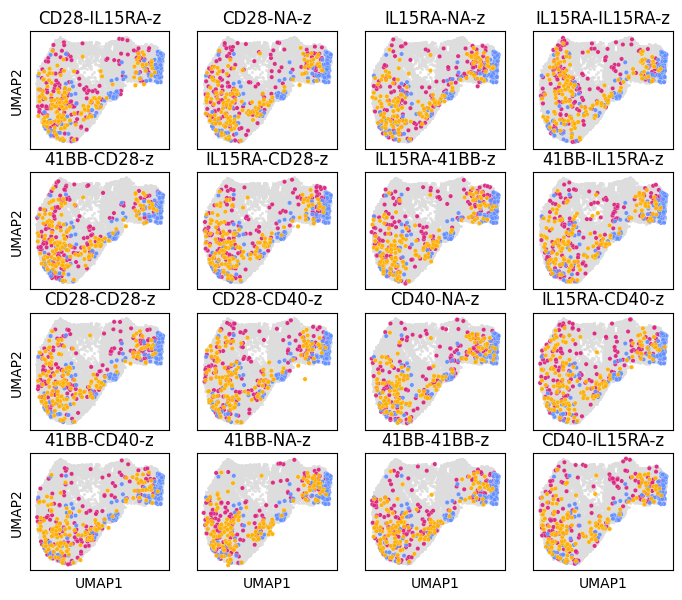

In [8]:
subset="CD4"
adata = sc.read_h5ad(f'/Users/alicedriessen/Box/LegacyFromOldColleagues/Alice/CAR_Tcells/Model/OT/{subset}.h5ad')
adata.X = adata.layers['logcounts']
with open(features, "r") as f:
    genes = f.read().splitlines()
sel_adata = adata[:, genes]
umapper = umap.UMAP(random_state=1234)
Y1 = umapper.fit_transform(sel_adata.X)

fig, axes = plt.subplots(nrows=4,ncols=4, sharex=True, sharey=True, figsize=(8.3, 7))
flat_axes = axes.flatten()
i =0

config_path = f"{base_config_path}{subset}_esm_XL_tail_dim_FuncScore/config.yaml"
config = load_config(config_path)
config.model.checkpointing_path = f"{base_ckpt_path}{subset}_esm_XL_tail_dim_FuncScore/model"
config.data.file_path = f"/Users/alicedriessen/Box/LegacyFromOldColleagues/Alice/CAR_Tcells/Model/OT/{subset}.h5ad"
config.data.features = features
config.data.drugs_path = f"/Users/alicedriessen/Box/LegacyFromOldColleagues/Alice/CAR_Tcells/Model/OT/{subset}_sel_cars.txt"
config.model.embedding.model_dir = "/Users/alicedriessen/Box/LegacyFromOldColleagues/Alice/CAR_Tcells/Model/OT/embedding/"

for car in config.condition.conditions:
    if car in ["NA-NA-NA", "NA-NA-z"]:
        continue
    print(car)
    batch_size = min(sum(sel_adata.obs["CAR_Variant"]==car), sum(sel_adata.obs["CAR_Variant"]=="NA-NA-NA"))
    batch_size = floor(batch_size * config.data.split[1])
    config.data.batch_size=batch_size
    config.condition.conditions = [car]

    datamodule = ConditionalDataModule(config.data, config.condition, config.ae)
    trainer = ConditionalMongeTrainer.load_checkpoint(
        jobid=1,
        logger_path=logger_path, 
        config=config.model, 
        datamodule=datamodule, 
        ckpt_path=config.model.checkpointing_path
        )

    all_expr, all_meta = get_source_target_transport(datamodule=datamodule, 
                                                     trainer=trainer,
                                                     conditions=[car])

    Y2 = umapper.transform(all_expr)

    all_meta[["UMAP1", "UMAP2"]] = Y2

    sns.scatterplot(x=Y1[:, 0], y=Y1[:, 1], color=default_colors["grey"], s=5, ax=flat_axes[i], alpha=0.8, linewidth=0)
    sns.scatterplot(data=all_meta, x="UMAP1", y="UMAP2", hue="dtype", s=10, palette=ot_map, ax=flat_axes[i], alpha=0.95, linewidth=0.15)
    flat_axes[i].get_legend().remove()
    flat_axes[i].set_title(car)
    flat_axes[i].tick_params(which="both", axis="both", bottom=False, left=False, labelbottom=False, labelleft=False)
    i+=1
plt.savefig(f"{base_fig_save}{subset}_all.png", bbox_inches="tight", dpi=300)
plt.savefig(f"{base_fig_save}{subset}_all.pdf", bbox_inches="tight", dpi=300)
plt.show()

/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


IL15RA-CD40-z


2025-08-22 20:03:02.354 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for IL15RA-CD40-z
2025-08-22 20:03:02.642 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 20:03:02.649 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (1258,), valid: (315,), test: (0,).
2025-08-22 20:03:02.649 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-22 20:03:02.649 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 20:03:02.649 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 20:03:02.674 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarnin

Evaluating on validation set
(284, 5120)
CD40-CD40-z


2025-08-22 20:03:05.224 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD40-CD40-z
2025-08-22 20:03:05.631 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 20:03:05.640 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (1089,), valid: (273,), test: (0,).
2025-08-22 20:03:05.640 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-22 20:03:05.640 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 20:03:05.641 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 20:03:05.672 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning:

Evaluating on validation set
(272, 5120)
CD40-NA-z


2025-08-22 20:03:06.780 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD40-NA-z
2025-08-22 20:03:07.173 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 20:03:07.181 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (1004,), valid: (251,), test: (0,).
2025-08-22 20:03:07.182 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-22 20:03:07.182 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 20:03:07.182 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 20:03:07.207 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: '

Evaluating on validation set
(251, 5120)
IL15RA-41BB-z


2025-08-22 20:03:08.329 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for IL15RA-41BB-z
2025-08-22 20:03:08.765 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 20:03:08.776 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (964,), valid: (242,), test: (0,).
2025-08-22 20:03:08.777 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-22 20:03:08.777 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 20:03:08.777 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 20:03:08.812 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning

Evaluating on validation set
(241, 5120)
IL15RA-CTLA4-z


2025-08-22 20:03:09.861 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for IL15RA-CTLA4-z
2025-08-22 20:03:10.366 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 20:03:10.380 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (936,), valid: (234,), test: (0,).
2025-08-22 20:03:10.380 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-22 20:03:10.380 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 20:03:10.381 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 20:03:10.418 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarnin

Evaluating on validation set
(234, 5120)
IL15RA-NA-z


2025-08-22 20:03:11.417 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for IL15RA-NA-z
2025-08-22 20:03:11.967 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 20:03:11.978 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (925,), valid: (232,), test: (0,).
2025-08-22 20:03:11.978 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-22 20:03:11.978 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 20:03:11.979 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 20:03:12.012 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 

Evaluating on validation set
(231, 5120)
CD28-NA-z


2025-08-22 20:03:13.071 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD28-NA-z
2025-08-22 20:03:13.744 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 20:03:13.758 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (883,), valid: (221,), test: (0,).
2025-08-22 20:03:13.758 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-22 20:03:13.758 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 20:03:13.759 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 20:03:13.796 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'f

Evaluating on validation set
(220, 5120)
41BB-IL15RA-z


2025-08-22 20:03:14.836 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for 41BB-IL15RA-z
2025-08-22 20:03:15.343 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 20:03:15.352 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (844,), valid: (212,), test: (0,).
2025-08-22 20:03:15.352 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-22 20:03:15.352 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 20:03:15.353 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 20:03:15.384 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning

Evaluating on validation set
(211, 5120)
41BB-NA-z


2025-08-22 20:03:16.177 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for 41BB-NA-z
2025-08-22 20:03:16.646 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 20:03:16.654 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (789,), valid: (198,), test: (0,).
2025-08-22 20:03:16.654 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-22 20:03:16.654 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 20:03:16.655 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 20:03:16.686 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'f

Evaluating on validation set
(197, 5120)
CD40-CD28-z


2025-08-22 20:03:17.449 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD40-CD28-z
2025-08-22 20:03:18.062 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 20:03:18.071 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (774,), valid: (194,), test: (0,).
2025-08-22 20:03:18.072 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-22 20:03:18.072 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 20:03:18.072 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 20:03:18.104 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 

Evaluating on validation set
(193, 5120)
CD28-IL15RA-z


2025-08-22 20:03:18.952 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD28-IL15RA-z
2025-08-22 20:03:19.550 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 20:03:19.558 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (719,), valid: (180,), test: (0,).
2025-08-22 20:03:19.559 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-22 20:03:19.559 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 20:03:19.559 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 20:03:19.594 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning

Evaluating on validation set
(179, 5120)
CD28-CD28-z


2025-08-22 20:03:20.370 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD28-CD28-z
2025-08-22 20:03:20.900 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 20:03:20.909 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (672,), valid: (168,), test: (0,).
2025-08-22 20:03:20.910 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-22 20:03:20.910 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 20:03:20.910 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 20:03:20.937 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 

Evaluating on validation set
(168, 5120)
IL15RA-CD28-z


2025-08-22 20:03:21.682 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for IL15RA-CD28-z
2025-08-22 20:03:22.369 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 20:03:22.382 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (628,), valid: (157,), test: (0,).
2025-08-22 20:03:22.383 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-22 20:03:22.383 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 20:03:22.384 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 20:03:22.428 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning

Evaluating on validation set
(157, 5120)
41BB-41BB-z


2025-08-22 20:03:23.363 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for 41BB-41BB-z
2025-08-22 20:03:24.060 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 20:03:24.073 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (628,), valid: (157,), test: (0,).
2025-08-22 20:03:24.074 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-22 20:03:24.074 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 20:03:24.074 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 20:03:24.121 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 

Evaluating on validation set
(157, 5120)


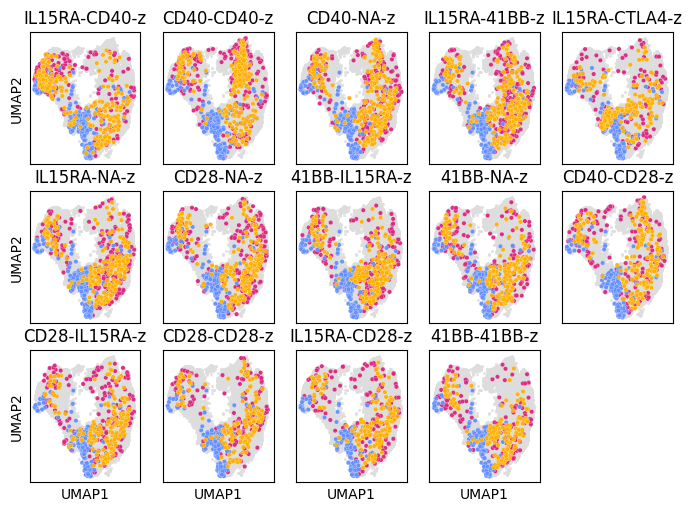

In [9]:
subset="CD8"
adata = sc.read_h5ad(f'/Users/alicedriessen/Box/LegacyFromOldColleagues/Alice/CAR_Tcells/Model/OT/{subset}.h5ad')
adata.X = adata.layers['logcounts']
with open(features, "r") as f:
    genes = f.read().splitlines()
sel_adata = adata[:, genes]
umapper = umap.UMAP(random_state=1234)
Y1 = umapper.fit_transform(sel_adata.X)

fig, axes = plt.subplots(nrows=3,ncols=5, sharex=True, sharey=True, figsize=(8.3, 5.85))
flat_axes = axes.flatten()
i =0

config_path = f"{base_config_path}{subset}_esm_XL_tail_dim_FuncScore/config.yaml"
config = load_config(config_path)
config.model.checkpointing_path = f"{base_ckpt_path}{subset}_esm_XL_tail_dim_FuncScore/model"
config.data.file_path = f"/Users/alicedriessen/Box/LegacyFromOldColleagues/Alice/CAR_Tcells/Model/OT/{subset}.h5ad"
config.data.features = features
config.data.drugs_path = f"//Users/alicedriessen/Box/LegacyFromOldColleagues/Alice/CAR_Tcells/Model/OT/{subset}_sel_cars.txt"
config.model.embedding.model_dir = "/Users/alicedriessen/Box/LegacyFromOldColleagues/Alice/CAR_Tcells/Model/OT/embedding/"

for car in config.condition.conditions:
    if car in ["NA-NA-NA", "NA-NA-z"]:
        continue
    print(car)
    batch_size = min(sum(sel_adata.obs["CAR_Variant"]==car), sum(sel_adata.obs["CAR_Variant"]=="NA-NA-NA"))
    batch_size = floor(batch_size * config.data.split[1])
    config.data.batch_size=batch_size
    config.condition.conditions = [car]

    datamodule = ConditionalDataModule(config.data, config.condition, config.ae)
    trainer = ConditionalMongeTrainer.load_checkpoint(
        jobid=1,
        logger_path=logger_path, 
        config=config.model, 
        datamodule=datamodule, 
        ckpt_path=config.model.checkpointing_path
        )

    all_expr, all_meta = get_source_target_transport(datamodule=datamodule, 
                                                     trainer=trainer,
                                                     conditions=[car])

    Y2 = umapper.transform(all_expr)

    all_meta[["UMAP1", "UMAP2"]] = Y2

    sns.scatterplot(x=Y1[:, 0], y=Y1[:, 1], color=default_colors["grey"], s=5, ax=flat_axes[i], alpha=0.8, linewidth=0)
    sns.scatterplot(data=all_meta, x="UMAP1", y="UMAP2", hue="dtype", s=10, palette=ot_map, ax=flat_axes[i], alpha=0.95, linewidth=0.15)
    flat_axes[i].get_legend().remove()
    flat_axes[i].set_title(car)
    flat_axes[i].tick_params(which="both", axis="both", bottom=False, left=False, labelbottom=False, labelleft=False)
    i+=1
fig.delaxes(flat_axes[-1])
plt.savefig(f"{base_fig_save}{subset}_all.png", bbox_inches="tight", dpi=300)
plt.savefig(f"{base_fig_save}{subset}_all.pdf", bbox_inches="tight", dpi=300)
plt.show()

## OOD CARs

In [10]:
with open("/Users/alicedriessen/Box/LegacyFromOldColleagues/Alice/CAR_Tcells/Model/OT/CD8_sel_cars.txt") as f:
    CD8_cars = f.readlines()
CD8_cars = [c[:-1] for c in CD8_cars]

with open("/Users/alicedriessen/Box/LegacyFromOldColleagues/Alice/CAR_Tcells/Model/OT/CD4_sel_cars.txt") as f:
    CD4_cars = f.readlines()
CD4_cars = [c[:-1] for c in CD4_cars]

/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


0 41BB-CTLA4-z


2025-08-22 20:03:52.442 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for 41BB-CTLA4-z
2025-08-22 20:03:52.935 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 20:03:52.948 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (248,), valid: (63,), test: (0,).
2025-08-22 20:03:52.948 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-22 20:03:52.948 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 20:03:52.949 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 20:03:52.993 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: '

Evaluating on validation set
(62, 5120)
1 CD28-41BB-z


2025-08-22 20:03:55.231 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD28-41BB-z
2025-08-22 20:03:55.844 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 20:03:55.858 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (172,), valid: (43,), test: (0,).
2025-08-22 20:03:55.858 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-22 20:03:55.858 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 20:03:55.859 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 20:03:55.892 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'f

Evaluating on validation set
(43, 5120)
2 CD28-CTLA4-z


2025-08-22 20:03:56.504 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD28-CTLA4-z
2025-08-22 20:03:57.095 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 20:03:57.108 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (214,), valid: (54,), test: (0,).
2025-08-22 20:03:57.108 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-22 20:03:57.108 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 20:03:57.109 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 20:03:57.152 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: '

Evaluating on validation set
(53, 5120)
3 CD40-41BB-z


2025-08-22 20:03:57.846 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD40-41BB-z
2025-08-22 20:03:58.605 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 20:03:58.615 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (556,), valid: (140,), test: (0,).
2025-08-22 20:03:58.615 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-22 20:03:58.616 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 20:03:58.616 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 20:03:58.648 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(139, 5120)


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


4 CD40-CD28-z


2025-08-22 20:04:01.333 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD40-CD28-z
2025-08-22 20:04:01.609 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 20:04:01.616 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (590,), valid: (148,), test: (0,).
2025-08-22 20:04:01.616 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-22 20:04:01.616 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 20:04:01.616 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 20:04:01.649 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: '

Evaluating on validation set
(147, 5120)
5 CD40-CD40-z


2025-08-22 20:04:02.294 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD40-CD40-z
2025-08-22 20:04:02.648 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 20:04:02.655 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (542,), valid: (136,), test: (0,).
2025-08-22 20:04:02.656 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-22 20:04:02.656 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 20:04:02.656 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 20:04:02.686 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: '

Evaluating on validation set
(135, 5120)
6 CD40-CTLA4-z


2025-08-22 20:04:03.414 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD40-CTLA4-z
2025-08-22 20:04:03.775 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 20:04:03.784 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (259,), valid: (65,), test: (0,).
2025-08-22 20:04:03.784 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-22 20:04:03.785 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 20:04:03.785 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 20:04:03.814 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: '

Evaluating on validation set
(64, 5120)
7 CTLA4-41BB-z


2025-08-22 20:04:04.353 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CTLA4-41BB-z
2025-08-22 20:04:04.675 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 20:04:04.683 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (188,), valid: (48,), test: (0,).
2025-08-22 20:04:04.683 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-22 20:04:04.683 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 20:04:04.684 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 20:04:04.710 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: '

Evaluating on validation set
(47, 5120)
8 CTLA4-CD28-z


2025-08-22 20:04:05.187 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CTLA4-CD28-z
2025-08-22 20:04:05.484 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 20:04:05.491 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (452,), valid: (113,), test: (0,).
2025-08-22 20:04:05.491 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-22 20:04:05.491 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 20:04:05.491 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 20:04:05.516 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 

Evaluating on validation set
(113, 5120)
9 CTLA4-CD40-z


2025-08-22 20:04:06.344 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CTLA4-CD40-z
2025-08-22 20:04:06.804 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 20:04:06.811 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (162,), valid: (41,), test: (0,).
2025-08-22 20:04:06.811 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-22 20:04:06.812 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 20:04:06.812 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 20:04:06.839 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: '

Evaluating on validation set
(40, 5120)
10 CTLA4-CTLA4-z


2025-08-22 20:04:07.597 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CTLA4-CTLA4-z
2025-08-22 20:04:07.949 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 20:04:07.956 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (222,), valid: (56,), test: (0,).
2025-08-22 20:04:07.956 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-22 20:04:07.957 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 20:04:07.957 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 20:04:07.988 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 

Evaluating on validation set
(55, 5120)
11 CTLA4-IL15RA-z


2025-08-22 20:04:08.864 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CTLA4-IL15RA-z
2025-08-22 20:04:09.407 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 20:04:09.415 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (152,), valid: (38,), test: (0,).
2025-08-22 20:04:09.415 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-22 20:04:09.416 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 20:04:09.416 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 20:04:09.463 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning:

Evaluating on validation set
(38, 5120)
12 CTLA4-NA-z


2025-08-22 20:04:10.381 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CTLA4-NA-z
2025-08-22 20:04:11.122 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 20:04:11.131 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (171,), valid: (43,), test: (0,).
2025-08-22 20:04:11.131 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-22 20:04:11.131 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 20:04:11.131 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 20:04:11.173 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'fo

Evaluating on validation set
(42, 5120)
13 IL15RA-CTLA4-z


2025-08-22 20:04:12.301 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for IL15RA-CTLA4-z
2025-08-22 20:04:13.141 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 20:04:13.149 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (364,), valid: (92,), test: (0,).
2025-08-22 20:04:13.149 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-22 20:04:13.150 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 20:04:13.150 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 20:04:13.197 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning:

Evaluating on validation set
(91, 5120)


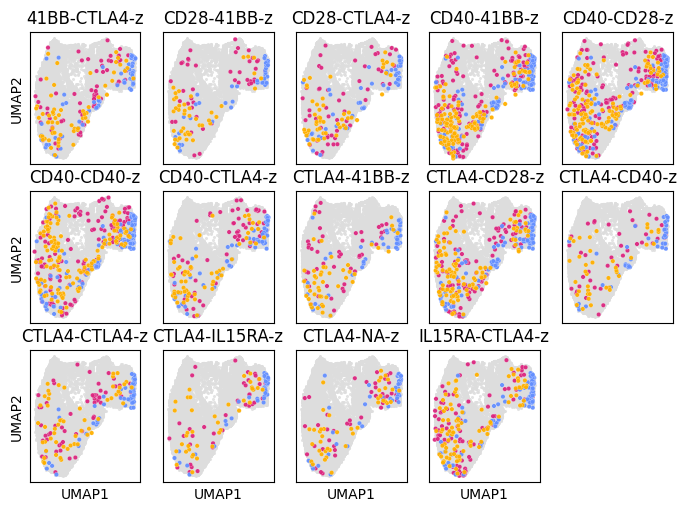

In [11]:
subset="CD4"

adata = sc.read_h5ad(f'/Users/alicedriessen/Box/LegacyFromOldColleagues/Alice/CAR_Tcells/Model/OT/{subset}.h5ad')
adata.X = adata.layers['logcounts']
with open(features, "r") as f:
    genes = f.read().splitlines()
sel_adata = adata[:, genes]
umapper = umap.UMAP(random_state=1234)
Y1 = umapper.fit_transform(sel_adata.X)

fig, axes = plt.subplots(nrows=3,ncols=5, sharex=True, sharey=True, figsize=(8.3, 5.85))
flat_axes = axes.flatten()
i =0

config_path = f"{base_config_path}{subset}_esm_XL_tail_dim_FuncScore/config.yaml"
config = load_config(config_path)
config.model.checkpointing_path = f"{base_ckpt_path}{subset}_esm_XL_tail_dim_FuncScore/model"
config.data.file_path = f"/Users/alicedriessen/Box/LegacyFromOldColleagues/Alice/CAR_Tcells/Model/OT/{subset}.h5ad"
config.data.features = features
config.data.drugs_path = f"/Users/alicedriessen/Box/LegacyFromOldColleagues/Alice/CAR_Tcells/Model/OT/{subset}_sel_cars.txt"
config.model.embedding.model_dir = "/Users/alicedriessen/Box/LegacyFromOldColleagues/Alice/CAR_Tcells/Model/OT/embedding/"

for car in sel_adata.obs["CAR_Variant"].unique():
    if car in ["NA-NA-NA", "NA-NA-z"] or car in CD4_cars:
        continue
    print(i, car)
    batch_size = min(sum(sel_adata.obs["CAR_Variant"]==car), sum(sel_adata.obs["CAR_Variant"]=="NA-NA-NA"))
    batch_size = floor(batch_size * config.data.split[1])
    config.data.batch_size=batch_size
    config.condition.conditions = [car]

    datamodule = ConditionalDataModule(config.data, config.condition, config.ae)
    trainer = ConditionalMongeTrainer.load_checkpoint(
        jobid=1,
        logger_path=logger_path, 
        config=config.model, 
        datamodule=datamodule, 
        ckpt_path=config.model.checkpointing_path
        )

    all_expr, all_meta = get_source_target_transport(datamodule=datamodule, 
                                                     trainer=trainer,
                                                     conditions=[car])

    Y2 = umapper.transform(all_expr)

    all_meta[["UMAP1", "UMAP2"]] = Y2

    sns.scatterplot(x=Y1[:, 0], y=Y1[:, 1], color=default_colors["grey"], s=5, ax=flat_axes[i], alpha=0.8, linewidth=0)
    sns.scatterplot(data=all_meta, x="UMAP1", y="UMAP2", hue="dtype", s=10, palette=ot_map, ax=flat_axes[i], alpha=0.95, linewidth=0.15)
    flat_axes[i].get_legend().remove()
    flat_axes[i].set_title(car)
    flat_axes[i].tick_params(which="both", axis="both", bottom=False, left=False, labelbottom=False, labelleft=False)
    i+=1
fig.delaxes(flat_axes[-1])
plt.savefig(f"{base_fig_save}OOD_{subset}_all.png", bbox_inches="tight", dpi=300)
plt.savefig(f"{base_fig_save}OOD_{subset}_all.pdf", bbox_inches="tight", dpi=300)
plt.show()

/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


41BB-CD28-z


2025-08-22 20:04:41.260 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for 41BB-CD28-z
2025-08-22 20:04:41.711 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 20:04:41.722 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (581,), valid: (146,), test: (0,).
2025-08-22 20:04:41.723 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-22 20:04:41.723 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 20:04:41.723 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 20:04:41.763 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 

Evaluating on validation set
(145, 5120)
41BB-CD40-z


2025-08-22 20:04:43.787 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for 41BB-CD40-z
2025-08-22 20:04:44.226 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 20:04:44.232 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (377,), valid: (95,), test: (0,).
2025-08-22 20:04:44.232 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-22 20:04:44.232 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 20:04:44.232 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 20:04:44.261 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: '

Evaluating on validation set
(94, 5120)
41BB-CTLA4-z


2025-08-22 20:04:45.012 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for 41BB-CTLA4-z
2025-08-22 20:04:45.664 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 20:04:45.677 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (212,), valid: (53,), test: (0,).
2025-08-22 20:04:45.677 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-22 20:04:45.678 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 20:04:45.678 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 20:04:45.716 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 

Evaluating on validation set
(53, 5120)
CD28-41BB-z


2025-08-22 20:04:46.420 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD28-41BB-z
2025-08-22 20:04:47.175 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 20:04:47.183 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (206,), valid: (52,), test: (0,).
2025-08-22 20:04:47.183 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-22 20:04:47.184 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 20:04:47.184 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 20:04:47.226 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: '

Evaluating on validation set
(51, 5120)
CD28-CD40-z


2025-08-22 20:04:48.059 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD28-CD40-z
2025-08-22 20:04:48.799 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 20:04:48.812 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (526,), valid: (132,), test: (0,).
2025-08-22 20:04:48.812 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-22 20:04:48.812 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 20:04:48.813 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 20:04:48.847 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 

Evaluating on validation set
(131, 5120)
CD28-CTLA4-z


2025-08-22 20:04:49.694 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD28-CTLA4-z
2025-08-22 20:04:50.319 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 20:04:50.328 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (350,), valid: (88,), test: (0,).
2025-08-22 20:04:50.328 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-22 20:04:50.329 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 20:04:50.329 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 20:04:50.365 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 

Evaluating on validation set
(87, 5120)
CD40-41BB-z


2025-08-22 20:04:51.304 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD40-41BB-z
2025-08-22 20:04:52.078 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 20:04:52.093 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (487,), valid: (122,), test: (0,).
2025-08-22 20:04:52.093 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-22 20:04:52.093 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 20:04:52.094 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 20:04:52.149 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 

Evaluating on validation set
(121, 5120)
CD40-CTLA4-z


2025-08-22 20:04:53.196 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD40-CTLA4-z
2025-08-22 20:04:53.936 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 20:04:53.950 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (559,), valid: (140,), test: (0,).
2025-08-22 20:04:53.951 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-22 20:04:53.952 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 20:04:53.954 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 20:04:53.992 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning:

Evaluating on validation set
(139, 5120)
CD40-IL15RA-z


2025-08-22 20:04:54.792 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD40-IL15RA-z
2025-08-22 20:04:55.455 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 20:04:55.464 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (552,), valid: (139,), test: (0,).
2025-08-22 20:04:55.465 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-22 20:04:55.465 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 20:04:55.465 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 20:04:55.506 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning

Evaluating on validation set
(138, 5120)
CTLA4-41BB-z


2025-08-22 20:04:56.377 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CTLA4-41BB-z
2025-08-22 20:04:57.076 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 20:04:57.086 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (137,), valid: (35,), test: (0,).
2025-08-22 20:04:57.087 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-22 20:04:57.087 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 20:04:57.087 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 20:04:57.128 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 

Evaluating on validation set
(34, 5120)
CTLA4-CD28-z


2025-08-22 20:04:57.939 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CTLA4-CD28-z
2025-08-22 20:04:58.638 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 20:04:58.657 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (202,), valid: (51,), test: (0,).
2025-08-22 20:04:58.658 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-22 20:04:58.658 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 20:04:58.658 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 20:04:58.718 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 

Evaluating on validation set
(50, 5120)
CTLA4-CD40-z


2025-08-22 20:04:59.465 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CTLA4-CD40-z
2025-08-22 20:05:00.207 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 20:05:00.219 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (220,), valid: (56,), test: (0,).
2025-08-22 20:05:00.220 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-22 20:05:00.220 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 20:05:00.220 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 20:05:00.259 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 

Evaluating on validation set
(55, 5120)
CTLA4-CTLA4-z


2025-08-22 20:05:01.096 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CTLA4-CTLA4-z
2025-08-22 20:05:01.928 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 20:05:01.949 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (97,), valid: (25,), test: (0,).
2025-08-22 20:05:01.950 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-22 20:05:01.952 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 20:05:01.953 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 20:05:02.031 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 

Evaluating on validation set
(24, 5120)
CTLA4-IL15RA-z


2025-08-22 20:05:02.750 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CTLA4-IL15RA-z
2025-08-22 20:05:03.354 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 20:05:03.362 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (187,), valid: (47,), test: (0,).
2025-08-22 20:05:03.362 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-22 20:05:03.362 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 20:05:03.362 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 20:05:03.454 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning

Evaluating on validation set
(46, 5120)
CTLA4-NA-z


2025-08-22 20:05:04.102 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CTLA4-NA-z
2025-08-22 20:05:04.655 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 20:05:04.665 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (201,), valid: (51,), test: (0,).
2025-08-22 20:05:04.665 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-22 20:05:04.665 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 20:05:04.666 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 20:05:04.702 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'f

Evaluating on validation set
(50, 5120)
IL15RA-IL15RA-z


2025-08-22 20:05:05.443 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for IL15RA-IL15RA-z
2025-08-22 20:05:06.167 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-22 20:05:06.175 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (489,), valid: (123,), test: (0,).
2025-08-22 20:05:06.175 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-22 20:05:06.176 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-22 20:05:06.176 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-22 20:05:06.209 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarni

Evaluating on validation set
(122, 5120)


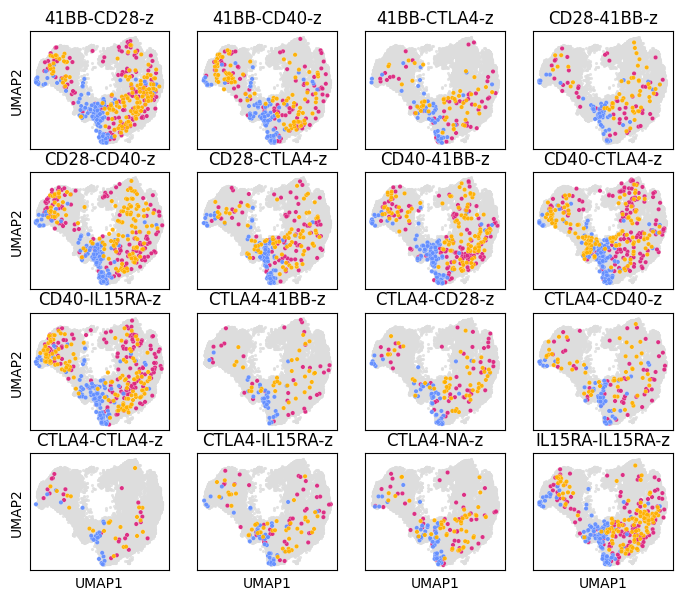

In [12]:
subset="CD8"
adata = sc.read_h5ad(f'/Users/alicedriessen/Box/LegacyFromOldColleagues/Alice/CAR_Tcells/Model/OT/{subset}.h5ad')
adata.X = adata.layers['logcounts']
with open(features, "r") as f:
    genes = f.read().splitlines()
sel_adata = adata[:, genes]
umapper = umap.UMAP(random_state=1234)
Y1 = umapper.fit_transform(sel_adata.X)

fig, axes = plt.subplots(nrows=4,ncols=4, sharex=True, sharey=True, figsize=(8.3, 7))
flat_axes = axes.flatten()
i =0

config_path = f"{base_config_path}{subset}_esm_XL_tail_dim_FuncScore/config.yaml"
config = load_config(config_path)
config.model.checkpointing_path = f"{base_ckpt_path}{subset}_esm_XL_tail_dim_FuncScore/model"
config.data.file_path = f"/Users/alicedriessen/Box/LegacyFromOldColleagues/Alice/CAR_Tcells/Model/OT/{subset}.h5ad"
config.data.features = features
config.data.drugs_path = f"/Users/alicedriessen/Box/LegacyFromOldColleagues/Alice/CAR_Tcells/Model/OT/{subset}_sel_cars.txt"
config.model.embedding.model_dir = "/Users/alicedriessen/Box/LegacyFromOldColleagues/Alice/CAR_Tcells/Model/OT/embedding/"

for car in sel_adata.obs["CAR_Variant"].unique():
    if car in ["NA-NA-NA", "NA-NA-z"] or car in CD8_cars:
        continue
    print(car)
    batch_size = min(sum(sel_adata.obs["CAR_Variant"]==car), sum(sel_adata.obs["CAR_Variant"]=="NA-NA-NA"))
    batch_size = floor(batch_size * config.data.split[1])
    config.data.batch_size=batch_size
    config.condition.conditions = [car]

    datamodule = ConditionalDataModule(config.data, config.condition, config.ae)
    trainer = ConditionalMongeTrainer.load_checkpoint(
        jobid=1,
        logger_path=logger_path, 
        config=config.model, 
        datamodule=datamodule, 
        ckpt_path=config.model.checkpointing_path
        )

    all_expr, all_meta = get_source_target_transport(datamodule=datamodule, 
                                                     trainer=trainer,
                                                     conditions=[car])

    Y2 = umapper.transform(all_expr)

    all_meta[["UMAP1", "UMAP2"]] = Y2

    sns.scatterplot(x=Y1[:, 0], y=Y1[:, 1], color=default_colors["grey"], s=5, ax=flat_axes[i], alpha=0.8, linewidth=0)
    sns.scatterplot(data=all_meta, x="UMAP1", y="UMAP2", hue="dtype", s=10, palette=ot_map, ax=flat_axes[i], alpha=0.95, linewidth=0.15)
    flat_axes[i].get_legend().remove()
    flat_axes[i].set_title(car)
    flat_axes[i].tick_params(which="both", axis="both", bottom=False, left=False, labelbottom=False, labelleft=False)
    i+=1
plt.savefig(f"{base_fig_save}OOD_{subset}_all.png", bbox_inches="tight", dpi=300)
plt.savefig(f"{base_fig_save}OOD_{subset}_all.pdf", bbox_inches="tight", dpi=300)
plt.show()

In [13]:
config.condition

DotMap(conditions=['IL15RA-IL15RA-z'], mode='homogeneous', split=[0.8, 0.2, 0.0], _ipython_display_=DotMap(), _repr_mimebundle_=DotMap())

# Only targets (Fig. 6)

In [14]:
with open("/Users/alicedriessen/Box/LegacyFromOldColleagues/Alice/CAR_Tcells/Model/OT/CD8_sel_cars.txt") as f:
    CD8_cars = f.readlines()
CD8_cars = [c[:-1] for c in CD8_cars]
adata = sc.read_h5ad('/Users/alicedriessen/Box/LegacyFromOldColleagues/Alice/CAR_Tcells/Model/OT/CD8.h5ad')
adata.X = adata.layers['logcounts']

In [15]:
sel_adata = adata[:, genes]
umapper = umap.UMAP(random_state=1234)
Y1 = umapper.fit_transform(sel_adata.X)

/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [16]:
cd40_cars = [c for c in CD8_cars if "CD40" in c]
ctla4_cars = [c for c in CD8_cars if "CTLA4" in c]

In [17]:
for car in cd40_cars:
    car_adata = sel_adata[sel_adata.obs["CAR_Variant"]==car, :]
    car_adata.obs[["UMAP1", "UMAP2"]] = umapper.transform(car_adata.X)

    sns.scatterplot(x=Y1[:, 0], y=Y1[:, 1], color=default_colors["grey"], s=5, alpha=0.8, linewidth=0)
    sns.scatterplot(data=car_adata.obs, x="UMAP1", y="UMAP2", s=20, palette=ot_map, alpha=0.95, linewidth=0.15, c=default_colors["pink"])
    plt.legend([],[], frameon=False)
    plt.tick_params(which="both", axis="both", bottom=False, left=False, labelbottom=False, labelleft=False)
    plt.xlabel("UMAP1", fontsize=18)
    plt.ylabel("UMAP2", fontsize=18)
    plt.savefig(f"{base_fig_save}CD8_adata_{car}_mapped.png", bbox_inches="tight", dpi=300)
    plt.savefig(f"{base_fig_save}CD8_adata_{car}_mapped.pdf", bbox_inches="tight", dpi=300)
    plt.close()

/var/folders/02/gztwz1tj1051mtt_ykv6v7940000gn/T/ipykernel_26231/1150664281.py:3: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  car_adata.obs[["UMAP1", "UMAP2"]] = umapper.transform(car_adata.X)
/var/folders/02/gztwz1tj1051mtt_ykv6v7940000gn/T/ipykernel_26231/1150664281.py:6: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=car_adata.obs, x="UMAP1", y="UMAP2", s=20, palette=ot_map, alpha=0.95, linewidth=0.15, c=default_colors["pink"])
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/var/folders/02/gztwz1tj1051mtt_ykv6v7940000gn/T/ipykernel_26231/1150664281.py:3: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  car_adata.obs[["UMAP1", "UMAP2"]] = umapper.

/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/var/folders/02/gztwz1tj1051mtt_ykv6v7940000gn/T/ipykernel_26231/4053610062.py:3: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  car_adata.obs[["UMAP1", "UMAP2"]] = umapper.transform(car_adata.X)
/var/folders/02/gztwz1tj1051mtt_ykv6v7940000gn/T/ipykernel_26231/4053610062.py:6: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=car_adata.obs, x="UMAP1", y="UMAP2", s=20, palette=ot_map, alpha=0.95, linewidth=0.15, c=default_colors["pink"])


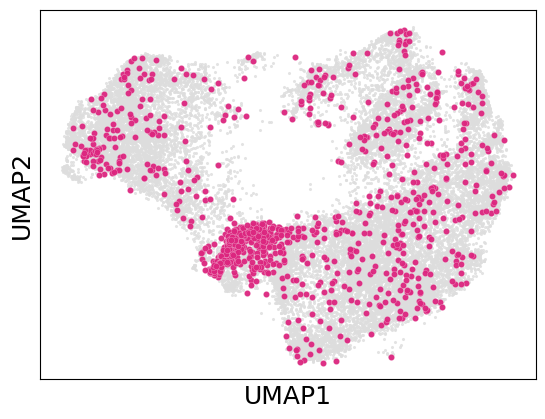

In [18]:
for car in ctla4_cars:
    car_adata = sel_adata[sel_adata.obs["CAR_Variant"]==car, :]
    car_adata.obs[["UMAP1", "UMAP2"]] = umapper.transform(car_adata.X)

    sns.scatterplot(x=Y1[:, 0], y=Y1[:, 1], color=default_colors["grey"], s=5, alpha=0.8, linewidth=0)
    sns.scatterplot(data=car_adata.obs, x="UMAP1", y="UMAP2", s=20, palette=ot_map, alpha=0.95, linewidth=0.15, c=default_colors["pink"])
    plt.legend([],[], frameon=False)
    plt.tick_params(which="both", axis="both", bottom=False, left=False, labelbottom=False, labelleft=False)
    plt.xlabel("UMAP1", fontsize=18)
    plt.ylabel("UMAP2", fontsize=18)
    plt.savefig(f"{base_fig_save}CD8_adata_{car}_mapped.png", bbox_inches="tight", dpi=300)
    plt.savefig(f"{base_fig_save}CD8_adata_{car}_mapped.pdf", bbox_inches="tight", dpi=300)
    plt.show()
    plt.close()